In [1]:
from json import loads
import pandas as pd
from datetime import datetime
import sys
import os
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
script_path = os.path.abspath("../")
sys.path.append(script_path)

from utils import generic_bar_graph, generic_distribution_plot, generic_plot_boxplots

In [3]:
__QUADRANTS = {
    "first": {"top_left": (0, 0), "bottom_right": (25, 25)},
    "second": {"top_left": (26, 0), "bottom_right": (50, 25)},
    "third": {"top_left": (51, 0), "bottom_right": (75, 25)},
    "fourth": {"top_left": (76, 0), "bottom_right": (100, 25)},
    "fifth": {"top_left": (0, 26), "bottom_right": (25, 50)},
    "sixth": {"top_left": (26, 26), "bottom_right": (50, 50)},
    "seventh": {"top_left": (51, 26), "bottom_right": (75, 50)},
    "eighth": {"top_left": (76, 26), "bottom_right": (100, 50)},
    "ninth": {"top_left": (0, 51), "bottom_right": (25, 75)},
    "tenth": {"top_left": (26, 51), "bottom_right": (50, 75)},
    "eleventh": {"top_left": (51, 51), "bottom_right": (75, 75)},
    "twelfth": {"top_left": (76, 51), "bottom_right": (100, 75)},
    "thirteenth": {"top_left": (0, 76), "bottom_right": (25, 100)},
    "fourteenth": {"top_left": (26, 76), "bottom_right": (50, 100)},
    "fifteenth": {"top_left": (51, 76), "bottom_right": (75, 100)},
    "sixteenth": {"top_left": (76, 76), "bottom_right": (100, 100)}
}

In [4]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)

In [113]:
%load_ext autoreload
%autoreload 2

# Carregando e configurando o dataset

In [5]:
df = pd.read_csv('../csv_datasets/data_from_all_players_tournaments_seasons_dataset.csv')

In [ ]:
df.head()

## Removendo colunas desnecessárias

In [6]:
df.drop('Unnamed: 0', axis=1, inplace=True)

## Renomeando colunas

In [7]:
df.rename(columns={'points': 'heatmap'}, inplace=True)

## Extraindo dados dos jogadores para o Dataset

In [8]:
df['player'] = df['player'].apply(eval)

In [9]:
df_players = pd.json_normalize(df['player'])

In [10]:
df = pd.concat([df, df_players], axis=1)

In [11]:
df = df[
    [
        'positive',
        'negative',
        'positions',
        'heatmap',
        'matches',
        'statistics',
        'team',
        'season',
        'tournament',
        'name',
        'position',
        'height',
        'preferredFoot',
        'proposedMarketValue',
        'contractUntilTimestamp',
        'team.shortName',
        'team.tournament.name',
        'team.tournament.category.name',
        'team.tournament.category.country.name',
        'id',
        'retired',
        'dateOfBirthTimestamp',
        'deceased'
    ]
].copy()

In [12]:
df.rename(columns={'team.shortName': 'current_team',
                   'team.tournament.name': 'current_team_tournament', 
                   'team.tournament.category.name': 'current_team_tournament_category',
                   'team.tournament.category.country.name': 'current_team_country',
                   'id': 'player_id'}, inplace=True)

## Extraindo dados dos times da temporada do jogador

In [13]:
df['team'] = df['team'].apply(eval)

In [14]:
df_team = pd.json_normalize(df['team'])

In [15]:
df_team.rename(columns={'name': 'season_team',
                   'shortName': 'season_team_shortname', }, inplace=True)

In [16]:
df = pd.concat([df, df_team], axis=1)

In [17]:
df = df.iloc[:, :26]

In [18]:
df.drop(['team', 'slug'], axis=1, inplace=True)

## Extraindo dados das estatisticas para o Dataset

In [19]:
df['statistics'] = df['statistics'].apply(eval)

In [20]:
df_statistics = pd.json_normalize(df['statistics'])

In [21]:
df = pd.concat([df, df_statistics], axis=1)

In [22]:
df.drop('statistics', axis=1, inplace=True)

## Criando algumas colunas para auxiliar na análise

In [23]:
def calculate_age(birth_timestamp):
    age = None
    if not pd.isna(birth_timestamp):

        birth_date = datetime.fromtimestamp(birth_timestamp)

        current_date = datetime(2025, 3, 20, 21, 4)
        
        age = current_date.year - birth_date.year - ((current_date.month, current_date.day) < (birth_date.month, birth_date.day))
    
    return age

In [24]:
df['age'] = df['dateOfBirthTimestamp'].apply(calculate_age)
df = df.drop('dateOfBirthTimestamp', axis=1)

# Analise exploratória

## Identificando valores nulos - Dados dos jogadores

In [ ]:
df[[
    'positive', 'negative', 'positions', 'heatmap', 'matches', 'season',
       'tournament', 'name', 'position', 'height', 'preferredFoot',
       'proposedMarketValue', 'contractUntilTimestamp', 'current_team',
       'current_team_tournament', 'current_team_tournament_category',
       'current_team_country', 'player_id', 'retired', 'deceased',
       'season_team', 'season_team_shortname', 'age'
       ]].info(verbose=True, show_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22727 entries, 0 to 22726
Data columns (total 23 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   positive                          22727 non-null  object 
 1   negative                          22727 non-null  object 
 2   positions                         22727 non-null  object 
 3   heatmap                           22638 non-null  object 
 4   matches                           22638 non-null  float64
 5   season                            22727 non-null  object 
 6   tournament                        22727 non-null  object 
 7   name                              22727 non-null  object 
 8   position                          22718 non-null  object 
 9   height                            22384 non-null  float64
 10  preferredFoot                     21672 non-null  object 
 11  proposedMarketValue               21750 non-null  float64
 12  cont

#### Matches e Heatmap

Explicações para valores nulos

- heatmap: Jogadores que jogaram menos de um jogo ou estão aposentados
- matches: Mesma coisa que o heatmap

In [ ]:
df[df['heatmap'].isnull()].head()

In [ ]:
df[df['heatmap'].isnull()]['minutesPlayed'].value_counts()

In [ ]:
df[(df['heatmap'].isnull()) & (df['minutesPlayed'] == 90)]

In [ ]:
df[df['heatmap'].isnull()]['retired'].value_counts()

In [ ]:
df[(df['heatmap'].isnull()) & (df['retired'].isna())].head()

In [ ]:
df[(df['heatmap'].isnull()) & (~df['matches'].isnull())].head()

#### Position

São poucos jogadores, que jogaram poucos minutos e geralmente são jovens

In [ ]:
df[df['position'].isnull()]['minutesPlayed']

In [ ]:
df[df['position'].isnull()][['name', 'age', 'player_id']]

### Jogadores sem idade

Também o padrão se repete, são jogadores que jogaram muito pouco e não há muitas informações sobre eles

In [ ]:
len(df[df['age'].isnull()])

In [ ]:
df[df['age'].isnull()]['minutesPlayed'].value_counts()

### Jogadores mortos

Existem nove jogadores que faleceram

In [ ]:
df['deceased'].value_counts()

In [ ]:
df[df['deceased'] == True]

### height

Aparentemente não há um padrão para a altura não aparecer em alguns jogadores. Ela será preenchida na etapa de pré processamento

In [ ]:
df['height'].info(verbose=True, show_counts=True)

In [ ]:
grouped_data = df[df['height'].isnull()].groupby('tournament').count().reset_index().sort_values('name')

In [ ]:
generic_bar_graph(categories=grouped_data['tournament'], values=grouped_data['name'], title='Jogadores sem altura por liga', x_label='Número de jogadores', y_label='Liga', x_rotation=90)

In [ ]:
grouped_data = df[df['height'].isnull()].groupby(['tournament', 'season'])['minutesPlayed'].max().reset_index().sort_values('minutesPlayed')

In [ ]:
generic_bar_graph(categories=grouped_data['tournament'], values=grouped_data['name'], title='Jogadores sem altura por liga', x_label='Número de jogadores', y_label='Liga', x_rotation=90)

In [ ]:
stacked_data = grouped_data.pivot_table(index='season', columns='tournament', values='minutesPlayed')

In [ ]:
stacked_data

In [ ]:
import matplotlib.pyplot as plt

stacked_data.plot(kind='bar', stacked=True, figsize=(12, 6), colormap="viridis")

# Personalizar o gráfico
plt.title('Distribuição dos Minutos Jogados por Temporada e Liga')
plt.xlabel('Temporada')
plt.ylabel('Minutos Jogados')
plt.legend(title='Liga', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


### preferredFoot

Parece que ocorreu um problema na coleta destes dados. Apenas para estes jogadores, vou refazer as coletas de dados ou posso inserir a moda nessa caso

In [ ]:
df[df['preferredFoot'].isnull()][['tournament', 'season', 'name', 'player_id']]

### retired and deceased

Alguns jogadores realmente não tem essa informação. Estes serão considerados jogadores normais

In [ ]:
df[df['deceased'].isnull()][['tournament', 'season', 'name', 'player_id']]

### Jogadores que não jogaram nenhum minuto na temporada

In [126]:
len(df[df['minutesPlayed'] == 0])

16

### Jogadores aposentados

In [124]:
len(df[df['retired'] == True])

431

## Identificando valores nulos - Estatisticas dos jogadores

In [42]:
df.iloc[:,22:].info(verbose=True, show_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22727 entries, 0 to 22726
Data columns (total 113 columns):
 #    Column                        Non-Null Count  Dtype  
---   ------                        --------------  -----  
 0    season_team_shortname         22727 non-null  object 
 1    rating                        22727 non-null  float64
 2    totalRating                   22727 non-null  float64
 3    countRating                   22727 non-null  int64  
 4    goals                         22727 non-null  int64  
 5    bigChancesCreated             22727 non-null  int64  
 6    bigChancesMissed              22727 non-null  int64  
 7    assists                       22475 non-null  float64
 8    goalsAssistsSum               22727 non-null  int64  
 9    accuratePasses                22727 non-null  int64  
 10   inaccuratePasses              22727 non-null  int64  
 11   totalPasses                   22727 non-null  int64  
 12   accuratePassesPercentage      22727 non-null

### assists

Realmente parece que alguns jogadores não tem essa característica computada. Vou preencher esses valores faltantes na etapa de pré-processamento

In [ ]:
df[df['assists'].isnull()]['position'].value_counts()

In [ ]:
df[df['assists'].isnull()].head(5)

### goalKicks

Não sei se essa variável é tão util. Relacionada ao número de tiros de meta de um jogador. Grande maioria não tem por que não bate tiro de meta

In [ ]:
df[(df['goalKicks'] > 0)][['tournament', 'season', 'name', 'player_id' ,'goalKicks']].head(5)

In [ ]:
df[(df['goalKicks'] > 0) & (df['position'] == 'G')][['tournament', 'season', 'name', 'goalKicks']].head(5)

In [ ]:
df[~df['goalKicks'].isnull()].head(5)

### ballRecovery e goalsPrevented

Talvez seja uma estatistica que não guardam muito. Nem todo jogador deve ter esse tipo de ação no jogo

### expectedAssists e expectedGoals

Aparentemente, nem todos os jogadores tem essa estatística calculada. Melhor analisar uma estratética para imputar isso no pré-processamento

In [ ]:
df[df['expectedAssists'].isnull()][['tournament', 'season', 'player_id', 'name']].head()

In [ ]:
df[(df['expectedAssists'].isnull()) & (df['assists'] > 0)][['tournament', 'season', 'player_id', 'name']]

In [ ]:
len(df[df['expectedAssists'].isnull()]['tournament'].unique())

In [ ]:
len(df[df['expectedGoals'].isnull()]['tournament'].unique())

In [ ]:
grouped_data = grouped_data = df[df['expectedAssists'].isnull()].groupby(['tournament'])['minutesPlayed'].max().reset_index().sort_values('minutesPlayed')

In [ ]:
generic_bar_graph(categories=grouped_data['tournament'], values=grouped_data['minutesPlayed'], title='Jogadores sem Xa', x_label='Número máximo de minutos em campo', y_label='Liga', x_rotation=90)

In [ ]:
grouped_data = grouped_data = df[df['expectedAssists'].isnull()].groupby(['tournament'])['assists'].max().reset_index().sort_values('assists')

In [ ]:
generic_bar_graph(categories=grouped_data['tournament'], values=grouped_data['assists'], title='Jogadores sem Xa', x_label='Número máximo de assistencias', y_label='Liga', x_rotation=90)

In [ ]:
df[(df['expectedAssists'].isnull()) & (df['assists'] > 20)][['tournament', 'season', 'player_id', 'name', 'assists']]

## Ajustando os valores nulos

In [142]:
df_analisys = df[
    ((df['deceased'].isnull()) | (df['deceased'] == False))
    &
    (~df['heatmap'].isnull())
    &
    (~df['position'].isnull())
    &
    (~df['age'].isnull())
    &
    ((df['retired'].isnull()) | (df['retired'] == False))
].copy()

In [143]:
len(df_analisys)

22180

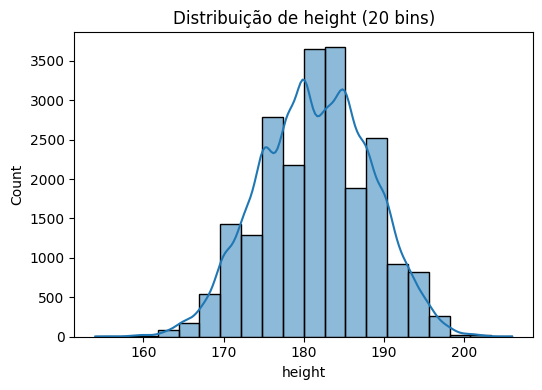

In [108]:
generic_distribution_plot(data=df_analisys, variables=['height'], bins_dict={'height': 20})

In [144]:
def set_player_height(row, mean_heights):
    if(pd.isna(row['height'])):
        if(row['position'] == 'G'):
            return mean_heights['G']
        elif(row['position'] == 'D'):
            return mean_heights['D']
        elif(row['position'] == 'M'):
            return mean_heights['M']
        
        return mean_heights['F']
    
    return row['height']

In [145]:
mean_heights = df.groupby('position')['height'].mean().round(0).to_dict()

In [146]:
df_analisys['height'] = df_analisys.apply(set_player_height, args=(mean_heights,), axis=1)

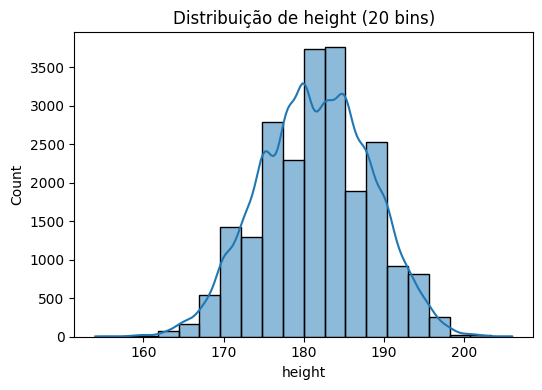

In [112]:
generic_distribution_plot(data=df_analisys, variables=['height'], bins_dict={'height': 20})

In [147]:
df_analisys['preferredFoot'] = df_analisys['preferredFoot'].fillna(lambda x: x.mode())
df_analisys['assists'] = df_analisys['assists'].fillna(0)
df_analisys['ownGoals'] = df_analisys['ownGoals'].fillna(0)
df_analisys['goalKicks'] = df_analisys['goalKicks'].fillna(0)
df_analisys['ballRecovery'] = df_analisys['ballRecovery'].fillna(0)
df_analisys['goalsPrevented'] = df_analisys['goalsPrevented'].fillna(0)
df_analisys['expectedAssists'] = df_analisys['expectedAssists'].fillna(0)
df_analisys['expectedGoals'] = df_analisys['expectedGoals'].fillna(0)
df_analisys['yellowRedCards'] = df_analisys['yellowRedCards'].fillna(0)
df_analisys['penaltyGoals'] = df_analisys['penaltyGoals'].fillna(0)
df_analisys['redCards'] = df_analisys['redCards'].fillna(0)

In [30]:
df_analisys.info(verbose=True, show_counts=True)

<class 'pandas.core.frame.DataFrame'>
Index: 22600 entries, 0 to 22726
Data columns (total 134 columns):
 #    Column                            Non-Null Count  Dtype  
---   ------                            --------------  -----  
 0    positive                          22600 non-null  object 
 1    negative                          22600 non-null  object 
 2    positions                         22600 non-null  object 
 3    heatmap                           22600 non-null  object 
 4    matches                           22600 non-null  float64
 5    season                            22600 non-null  object 
 6    tournament                        22600 non-null  object 
 7    name                              22600 non-null  object 
 8    position                          22600 non-null  object 
 9    height                            22600 non-null  float64
 10   preferredFoot                     22600 non-null  object 
 11   proposedMarketValue               21684 non-null  float64

## Analisando distribuição e outliers de variáveis

### Número de jogadores que aparecem mais de uma vez

A maioria dos jogadores aparece mais de uma vez no dataset. Alguns deles possuem dados apenas de uma temporada.

Para estes que aparecem apenas uma vez, eles podem ficar com menos dados nas agregações comparados aos que aparecem mais de uma vez.

Tem outro cenário, que seria o de simular quando jogadores entraram na esteira do algoritmo sem possuir dados anteriores. Seria um teste meio que em "produção"

In [26]:
df_two_seasons = df_analisys.groupby('player_id')['name'].size().reset_index()

In [ ]:
len(df_analisys)

In [ ]:
df_two_seasons['name'].value_counts().reset_index()

In [ ]:
len(df_analisys[df_analisys['season'].isin(['23_24', '2024'])])

In [ ]:
len(df_analisys[df_analisys['season'].isin(['22_23', '2023'])])

### Analisando quais jogadores trocaram de time na mesma temporada

In [ ]:
df_transfer = df_analisys.groupby(['player_id', 'season'])['season_team'].nunique().reset_index()

In [ ]:
df_transfer[(df_transfer['season_team'] > 1)]

In [ ]:
df_transfer[(df_transfer['season_team'] > 1) & (df_transfer['season'].isin(['23_24', '2024']))]

In [ ]:
df_analisys[df_analisys['player_id'] == 15190]

### Filtrando apenas a última temporada

In [148]:
df_analisys = df_analisys[df_analisys['season'].isin(['2024', '23_24'])]

In [46]:
df_analisys.info(verbose=True, show_counts=True)

<class 'pandas.core.frame.DataFrame'>
Index: 11364 entries, 0 to 22186
Data columns (total 135 columns):
 #    Column                            Non-Null Count  Dtype  
---   ------                            --------------  -----  
 0    positive                          11364 non-null  object 
 1    negative                          11364 non-null  object 
 2    positions                         11364 non-null  object 
 3    heatmap                           11364 non-null  object 
 4    matches                           11364 non-null  float64
 5    season                            11364 non-null  object 
 6    tournament                        11364 non-null  object 
 7    name                              11364 non-null  object 
 8    position                          11364 non-null  object 
 9    height                            11170 non-null  float64
 10   preferredFoot                     10790 non-null  object 
 11   proposedMarketValue               10925 non-null  float64

### Características dos jogadores

In [149]:
df_player_characteristics = df_analisys[['positions','heatmap','matches', 'season', 'tournament', 'name', 'position', 'height', 
 'preferredFoot', 'proposedMarketValue', 'contractUntilTimestamp', 
 'current_team', 'current_team_tournament', 'current_team_tournament_category', 
 'current_team_country', 'player_id', 'retired', 'age', 
 'deceased', 'season_team', 'season_team_shortname']].copy()

In [ ]:
df_player_characteristics.info(verbose=True)

Das variáveis acima, o que eu acho que pode ser interessante para o modelo:

- heatmap
- matches
- position
- height
- preferredFoot
- age

#### Analisando distribuição das variáveis

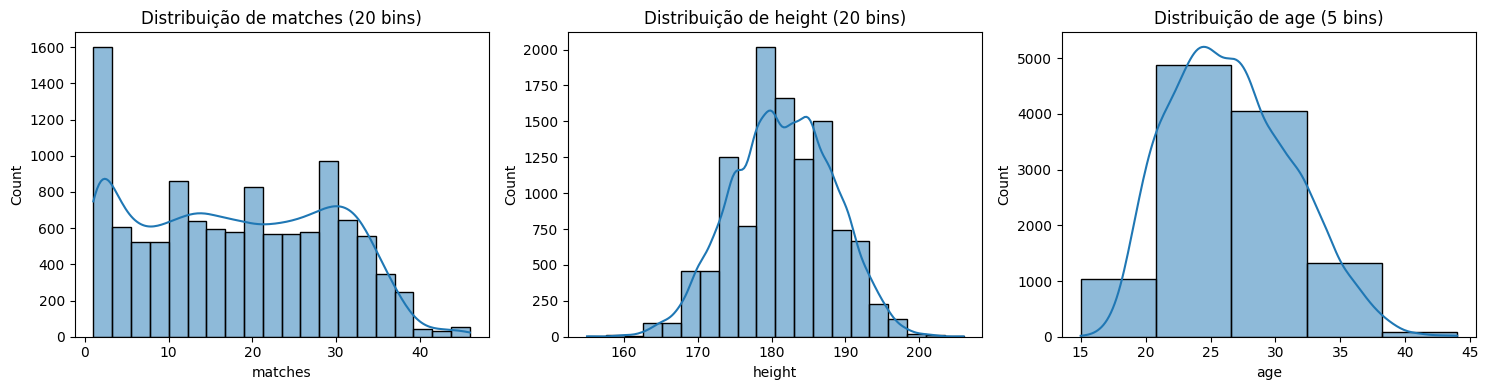

In [123]:
generic_distribution_plot(df_player_characteristics, ['matches', 'height', 'age'], graphs_per_row=3, bins_dict={'matches': 20, 'height': 20, 'age': 5})

#### Analisando valores incomuns na variável age

Um jogador está com a idade incorreta. Ele será removido

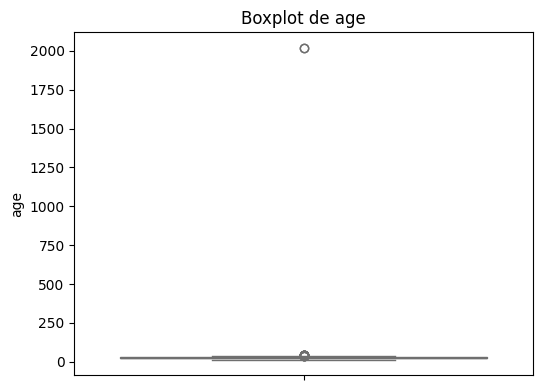

In [150]:
generic_plot_boxplots(df_player_characteristics, ['age'])

In [ ]:
print(df[df['age'] > 1000]['dateOfBirthTimestamp'])

In [ ]:
df[df['age'] > 1000]

In [151]:
df_player_characteristics = df_player_characteristics[df_player_characteristics['age'] < 60]

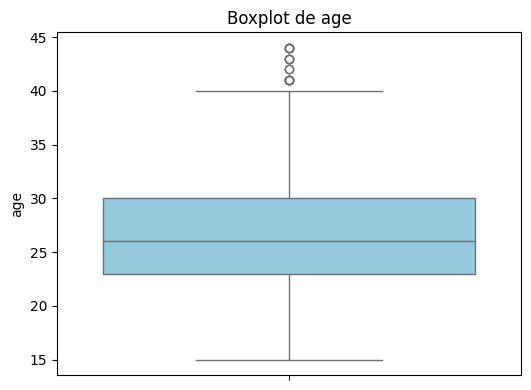

In [152]:
generic_plot_boxplots(df_player_characteristics, ['age'])

In [153]:
df_player_characteristics['age'].describe()

count    11242.000000
mean        26.516634
std          4.623570
min         15.000000
25%         23.000000
50%         26.000000
75%         30.000000
max         44.000000
Name: age, dtype: float64

In [ ]:
df_player_characteristics[df_player_characteristics['age'] == 15]

In [37]:
# Calcular Q1, Q3 e IQR
Q1 = df['age'].quantile(0.25)
Q3 = df['age'].quantile(0.75)
IQR = Q3 - Q1

# Definir limites para outliers
limite_inferior = Q1 - 1.5 * IQR
limite_superior = Q3 + 1.5 * IQR

# Filtrar apenas os outliers
outliers = df[(df['age'] < limite_inferior) | 
              (df['age'] > limite_superior)]

len(outliers)

73

#### Analisando outliers para a variável matches

Esta variável não tem outliers fora do iterquartil range, mas é interessante analisar posteriormente o impacto de poucos jogos nas estatisticas

In [ ]:
generic_plot_boxplots(df_player_characteristics, ['matches'])

In [31]:
df_player_characteristics['matches'].describe()

count    11364.000000
mean        17.904699
std         11.274794
min          1.000000
25%          8.000000
50%         18.000000
75%         28.000000
max         46.000000
Name: matches, dtype: float64

#### Analisando outliers para a vairável height

Os valores, mesmo sendo outliers, são genuinos para essa variável. Fiz uma análise da média de altura por posição, o que pode ser útil posteriormente para pós processamento

In [ ]:
generic_plot_boxplots(df_player_characteristics, ['height'])

In [ ]:
df_player_characteristics['height'].describe()

In [ ]:
df_mean_height_per_position = df_player_characteristics.groupby(['position'])['height'].mean().reset_index()

In [ ]:
df_mean_height_per_position

In [ ]:
generic_bar_graph(categories=df_mean_height_per_position['position'], values=df_mean_height_per_position['height'], title='Média de Altura Por Posição', x_label='Posição', y_label='Média de Altura', x_rotation=90)

In [ ]:
df_mean_height_per_position = df_player_characteristics.groupby(['position'])['height'].median().reset_index()

In [ ]:
df_mean_height_per_position

In [ ]:
generic_bar_graph(categories=df_mean_height_per_position['position'], values=df_mean_height_per_position['height'], title='Mediana de Altura Por Posição', x_label='Posição', y_label='Mediana de Altura', x_rotation=90)

#### Analisando número de valores nas variáveis preferredFoot e position

O pé preferido do jogador terá algum valor preditivo?

As posições aqui não são especificas, apenas genéricas onde o jogador ocupa no campo

In [35]:
preferred_foot_grouped_data = df_player_characteristics.groupby(['preferredFoot']).size().reset_index()

In [36]:
preferred_foot_grouped_data

,preferredFoot,0
0,Both,520
1,Left,2722
2,Right,7548


In [ ]:
generic_bar_graph(categories=preferred_foot_grouped_data['preferredFoot'], values=preferred_foot_grouped_data[0], title='Pé preferido do jogador', x_label='Pé', y_label='Contagem', x_rotation=90)

In [ ]:
position_grouped_data = df_player_characteristics.groupby(['position']).size().reset_index().sort_values(0)

In [ ]:
generic_bar_graph(categories=position_grouped_data['position'], values=position_grouped_data[0], title='Número de jogadores por posição', x_label='Posição', y_label='Contagem', x_rotation=90)

#### Decodificando o heatmap

In [28]:
df_player_characteristics[['heatmap', 'player_id', 'season', 'tournament', 'name']]

,heatmap,player_id,season,tournament,name
0,"[{'x': 30, 'y': 10, 'count': 1}, {'x': 30, 'y'...",814221,23_24,2_bundesliga,Manuel Feil
1,"[{'x': 72, 'y': 7, 'count': 1}, {'x': 72, 'y':...",1085304,23_24,2_bundesliga,Marco Pledl
2,"[{'x': 28, 'y': 51, 'count': 2}, {'x': 28, 'y'...",845653,23_24,2_bundesliga,Carlo Sickinger
3,"[{'x': 73, 'y': 32, 'count': 1}, {'x': 73, 'y'...",50968,23_24,2_bundesliga,Terrence Boyd
4,"[{'x': 18, 'y': 28, 'count': 1}, {'x': 18, 'y'...",1000541,23_24,2_bundesliga,Andi Hoti
...,...,...,...,...,...
22182,"[{'x': 81, 'y': 45, 'count': 1}, {'x': 81, 'y'...",838640,23_24,pro_league,Wilfried Kanga
22183,"[{'x': 68, 'y': 89, 'count': 4}, {'x': 68, 'y'...",902987,23_24,pro_league,Loïc Lapoussin
22184,"[{'x': 21, 'y': 87, 'count': 1}, {'x': 21, 'y'...",149592,23_24,pro_league,Jacob Barrett Laursen
22185,"[{'x': 21, 'y': 16, 'count': 1}, {'x': 21, 'y'...",247471,23_24,pro_league,Casper Nielsen


In [28]:
import numpy as np

def create_heatmap_matrix(data):
    #heatmap_matrix = np.zeros((101, 101),  dtype=np.uint8)

    heatmap_matrix = np.full((101, 101), 255, dtype=np.uint8)

    for value in data:
        heatmap_matrix[value['x'], value['y']] = value['count']

    return heatmap_matrix

In [29]:
import cv2

def detect_key_points_heatmap(data):
    sift = cv2.SIFT_create()
    
    keypoints, descritores = sift.detectAndCompute(data, None)

    #imagem_com_keypoints = cv2.drawKeypoints(data, keypoints, data) - Debug

    return keypoints

In [30]:
def detect_player_quadrant(keypoints):

    quatrand_counts = {}

    for kp in keypoints:
        x, y = kp.pt  # pt contém as coordenadas (x, y) do keypoint
        x = int(x)
        y = int(y)

        for quadrant_name, boundaries in __QUADRANTS.items():
            top_left = boundaries["top_left"]
            bottom_right = boundaries["bottom_right"]
            
            if (top_left[0] <= x <= bottom_right[0] and top_left[1] <= y <= bottom_right[1]):
                if(quadrant_name not in quatrand_counts.keys()):
                    quatrand_counts[quadrant_name] = 1
                else:
                    quatrand_counts[quadrant_name] += 1

    if(len(quatrand_counts) > 0):
        quatrand_counts = sorted(quatrand_counts, key=lambda x: quatrand_counts[x], reverse=True)

        top_3_quadrant = ", ".join(quatrand_counts[:3])

        return top_3_quadrant
    
    return None

In [31]:
df_player_characteristics['heatmap'] = df_player_characteristics['heatmap'].apply(eval)

In [32]:
df_player_characteristics['heatmap_matrix'] = df_player_characteristics['heatmap'].apply(create_heatmap_matrix)

In [33]:
df_player_characteristics['heatmap_matrix_key_points'] = df_player_characteristics['heatmap_matrix'].apply(detect_key_points_heatmap)

In [39]:
cv2.imwrite('teste_imagem.jpg', df_player_characteristics['heatmap_matrix'][0])

True

In [34]:
df_player_characteristics['top_3_quadrant'] = df_player_characteristics['heatmap_matrix_key_points'].apply(detect_player_quadrant)

##### Jogadores de teste

- Manuel Feil: 814221
- Carlo Sickinger: 845653
- Raphinha: 831005
- Wilfried Kanga: 838640
- Alex Mighten: 992044

In [60]:
df_player_characteristics[df_player_characteristics['player_id'].isin([831005, 814221, 838640, 845653, 992044])][['name', 'tournament','top_3_quadrant', 'player_id']]

,name,tournament,top_3_quadrant,player_id
0,Manuel Feil,2_bundesliga,"fifth, tenth, seventh",814221
2,Carlo Sickinger,2_bundesliga,"sixth, second, tenth",845653
20726,Raphinha,laliga,"tenth, fifth, ninth",831005
22182,Wilfried Kanga,pro_league,"sixth, eleventh, tenth",838640
22186,Alex Mighten,pro_league,"eighth, twelfth",992044


In [37]:
df_player_characteristics['top_3_quadrant'].nunique()

1897

In [103]:
cv2.imwrite('imagem_sift_992044_006.jpg', df_player_characteristics['heatmap_matrix_key_points'][22186])

True

In [57]:
def draw_quadrants(image_path, output_path):    
    # Carregar a imagem
    img = image_path
    
    # Se a imagem não estiver na escala 100x100, redimensionar
    original_height, original_width = img.shape[:2]
    scale_x = original_width / 100
    scale_y = original_height / 100
    
    # Criar uma cópia da imagem para desenhar
    img_with_quadrants = img.copy()
    
    # Desenhar as linhas dos quadrantes
    # Linhas horizontais
    for y in [25, 50, 75]:
        start_point = (0, int(y * scale_y))
        end_point = (original_width, int(y * scale_y))
        cv2.line(img_with_quadrants, start_point, end_point, (0, 255, 0), 1)
    
    # Linhas verticais
    for x in [25, 50, 75]:
        start_point = (int(x * scale_x), 0)
        end_point = (int(x * scale_x), original_height)
        cv2.line(img_with_quadrants, start_point, end_point, (0, 255, 0), 1)
    
    # Adicionar identificação dos quadrantes
    font = cv2.FONT_HERSHEY_SIMPLEX
    font_scale = 0.2  # Reduzido de 0.4 para 0.25
    font_color = (0, 0, 255)  # Vermelho
    font_thickness = 1
    
    for quadrant_name, coords in __QUADRANTS.items():
        # Calcular o centro do quadrante para posicionar o texto
        top_left = coords["top_left"]
        bottom_right = coords["bottom_right"]
        
        center_x = int((top_left[0] + bottom_right[0]) / 2 * scale_x)
        center_y = int((top_left[1] + bottom_right[1]) / 2 * scale_y)
        
        # Ajustar posição do texto para melhor visualização
        text_position = (center_x - 10, center_y)
        
        # Adicionar o texto
        cv2.putText(img_with_quadrants, quadrant_name, text_position, font, font_scale, font_color, font_thickness)
    
    # Salvar a imagem com os quadrantes
    cv2.imwrite(output_path, img_with_quadrants)

In [58]:
heatmap_matrix = np.full((101, 101), 255, dtype=np.uint8)

In [59]:
draw_quadrants(heatmap_matrix, 'teste_imagem_quadrante.jpg')

#### Analisando a variável positions

Poucos jogadores jogam em várias posições. Acredito que se for maior que três, da para dizer que ele joga em várias posições. Só tem que identificar qual é o setor do campo

Em duas, da para identificar em qual setor do campo o cara joga. Por exemplo, se ele joga no lado direito tanto na defesa e no ataque, da para dizer que ele é do lado direito. Analisar as possibilidades para esse caso

Em uma, preencher a variável position com essa

Para quem não tem, preencher como DC o de defesa, MC o de meio campo e ST o de atacante

Todos os goleiros recebem a posição GK

Não cheguei a uma posição sobre isso. Tem muitas variações possíveis.

In [ ]:
__TYPES_OF_POSITIONS = {
    'ST': 'center attack',
    'LW': 'side attack',
    'RW': 'side attack',
    'AM': 'center midfield',
    'ML': 'side midfield',
    'MC': 'center midfield',
    'MR': 'side midfield',
    'DM': 'center midfield',
    'DL': 'side deffense',
    'DC': 'side deffense',
    'DR': 'center deffense',
    'GK': 'goalkeeper'
}

In [ ]:
def set_player_position(row):

    if(len(row['positions']) == 0):
        if(row['position'] == 'F'):
            return 'ST'
        elif(row['position'] == 'M'):
            return 'MC'
        elif(row['position'] == 'D'):
            return 'DC'
        elif(row['position'] == 'G'):
            return 'GK'
    elif(len(row['positions'] == 1)):
        return row['positions'][0]
    else:
        

In [45]:
df_player_characteristics['positions'] = df_player_characteristics['positions'].apply(eval)

In [46]:
df_player_characteristics['posicao_vazia'] = df_player_characteristics['positions'].apply(lambda x: len(x))

In [47]:
df_player_characteristics.groupby('posicao_vazia').size()

posicao_vazia
0     511
1    6351
2    3814
3     631
4      40
5      14
6       3
dtype: int64

In [49]:
df_player_characteristics[df_player_characteristics['posicao_vazia'] == 2][:10]

,positions,heatmap,matches,season,tournament,name,position,height,preferredFoot,proposedMarketValue,contractUntilTimestamp,current_team,current_team_tournament,current_team_tournament_category,current_team_country,player_id,retired,age,deceased,season_team,season_team_shortname,posicao_vazia
0,"[MR, RW]","[{'x': 30, 'y': 10, 'count': 1}, {'x': 30, 'y'...",34.0,23_24,2_bundesliga,Manuel Feil,M,169.0,Right,420000.0,1.782778e+09,Elversberg,Regionalliga Southwest,Germany Amateur,Germany,814221,NaN,30.0,NaN,SV 07 Elversberg,Elversberg,2
7,"[MC, DM]","[{'x': 22, 'y': 70, 'count': 1}, {'x': 22, 'y'...",27.0,23_24,2_bundesliga,Florian Flick,M,190.0,Both,970000.0,1.782778e+09,Nürnberg,2. Bundesliga,Germany,Germany,944288,False,24.0,NaN,1. FC Nürnberg,Nürnberg,2
11,"[DC, DR]","[{'x': 30, 'y': 53, 'count': 1}, {'x': 30, 'y'...",18.0,23_24,2_bundesliga,Frederik Jäkel,D,193.0,Right,1300000.0,1.751242e+09,Elversberg,Regionalliga Southwest,Germany Amateur,Germany,987479,NaN,24.0,NaN,SV 07 Elversberg,Elversberg,2
18,"[MC, DM]","[{'x': 56, 'y': 86, 'count': 1}, {'x': 56, 'y'...",26.0,23_24,2_bundesliga,Leon Jensen,M,175.0,Both,1100000.0,1.751242e+09,Karlsruhe,2. Bundesliga,Germany,Germany,842202,NaN,27.0,NaN,Karlsruher SC,Karlsruhe,2
21,"[MC, DM]","[{'x': 29, 'y': 58, 'count': 1}, {'x': 29, 'y'...",21.0,23_24,2_bundesliga,Connor Krempicki,M,178.0,Both,415000.0,1.782778e+09,Magdeburg,3. Liga,Germany,Germany,171995,False,30.0,NaN,1. FC Magdeburg,Magdeburg,2
27,"[DL, LW]","[{'x': 64, 'y': 3, 'count': 1}, {'x': 64, 'y':...",24.0,23_24,2_bundesliga,Emmanuel Iyoha,D,191.0,Right,1300000.0,1.782778e+09,Fortuna,2. Bundesliga,Germany,Germany,790775,NaN,27.0,NaN,Fortuna Düsseldorf,Fortuna,2
28,"[MC, DM]","[{'x': 36, 'y': 46, 'count': 1}, {'x': 36, 'y'...",30.0,23_24,2_bundesliga,Yannik Engelhardt,M,184.0,Right,6500000.0,1.814314e+09,Como,"Serie C, Girone A",Italy,Italy,990209,False,24.0,NaN,Fortuna Düsseldorf,Fortuna,2
34,"[DR, MR]","[{'x': 75, 'y': 93, 'count': 1}, {'x': 75, 'y'...",21.0,23_24,2_bundesliga,Marco Meyerhofer,D,175.0,Right,855000.0,1.751242e+09,Fürth,Bundesliga,Germany,Germany,254135,NaN,29.0,False,SpVgg Greuther Fürth,Fürth,2
38,"[ST, RW]","[{'x': 71, 'y': 55, 'count': 1}, {'x': 71, 'y'...",27.0,23_24,2_bundesliga,Bryan Lasme,F,194.0,Right,565000.0,1.751242e+09,Grasshoppers,Super League,Switzerland,Switzerland,862011,NaN,26.0,NaN,FC Schalke 04,Schalke,2
39,"[DC, MC]","[{'x': 58, 'y': 33, 'count': 1}, {'x': 58, 'y'...",30.0,23_24,2_bundesliga,Boris Tomiak,D,197.0,Right,1900000.0,1.845936e+09,Hannover,2. Bundesliga,Germany,Germany,877306,False,26.0,NaN,1. FC Kaiserslautern,Kaiserslautern,2


### Estatísticas dos jogadores

In [38]:
df_statistics = df_analisys[(df['age'] < 60)].copy()

/tmp/ipykernel_870/2190145273.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_statistics = df_analisys[(df['age'] < 60)].copy()


#### Estatísticas relacionadas a chute ou gol

- As correlações mais positivas entre variáveis são aquelas que possuem relação entre totais e parciais, como total de chutes e o total de chutes dentro da área
- Mesma situação nas variáveis de porcentagem com o resto das outras características
- setPiece é gols de bola parada
- scorringFrequency é o quanto tempo em minutos que o jogador leva para fazer um gol, quanto menor, mais gols o cara faz. Quanto maior, mais tempo ele leva
- goalsFromInsideTheBox + goalsFromOutsideTheBox totaliza todos os gols do jogador na temporada

In [42]:
df_chute = df_statistics[[
    # Gols absolutos
    'goals',
    'penaltyGoals',
    'freeKickGoal',
    'headedGoals',

    #Variáveis de conversão
    'goalConversionPercentage',
    'penaltyConversion',
    'setPieceConversion',

    # Olhando para a perna ruim do cara, da pra montar um indicador se ele é bom ou não
    'leftFootGoals',
    'rightFootGoals',

    # Com os gols de penalti, da pra montar uma métrica de acurácia de penalti
    'attemptPenaltyMiss',
    'attemptPenaltyPost',
    'attemptPenaltyTarget',

    'scoringFrequency', # pode ser util
    
    # Da pra criar uma métrica de acurácia de chute
    'totalShots',
    'shotsOnTarget', 
    'shotsOffTarget',
    'hitWoodwork',

    # Da para resumir em uma só
    'goalsFromInsideTheBox',
    'shotsFromInsideTheBox',

    # Da para resumir em uma só
    'goalsFromOutsideTheBox',
    'shotsFromOutsideTheBox',
    
    #Isso pode ser util?
    'shotFromSetPiece',

    'bigChancesMissed', 
    'bigChancesCreated',

    'offsides'
]].copy()

##### Analisando descrição das variáveis

In [66]:
df_chute.describe()

,goals,penaltyGoals,freeKickGoal,headedGoals,goalConversionPercentage,penaltyConversion,setPieceConversion,leftFootGoals,rightFootGoals,attemptPenaltyMiss,attemptPenaltyPost,attemptPenaltyTarget,scoringFrequency,totalShots,shotsOnTarget,shotsOffTarget,hitWoodwork,goalsFromInsideTheBox,shotsFromInsideTheBox,goalsFromOutsideTheBox,shotsFromOutsideTheBox,shotFromSetPiece,bigChancesMissed,bigChancesCreated,offsides
count,11362.000000,11362.000000,11362.000000,11362.000000,11362.000000,11362.000000,11362.000000,11362.000000,11362.000000,11362.000000,11362.000000,11362.000000,11362.000000,11362.000000,11362.000000,11362.000000,11362.000000,11362.000000,11362.000000,11362.000000,11362.000000,11362.000000,11362.000000,11362.000000,11362.000000
mean,1.571290,0.136244,0.025260,0.258757,7.050903,6.255015,0.674497,0.482309,0.821686,0.005193,0.005369,0.028516,374.810317,15.138884,5.175673,5.986710,0.389632,1.351611,9.522883,0.219680,5.616001,0.496920,1.456522,1.766414,2.019011
std,2.895911,0.632086,0.182345,0.706282,11.632552,23.457979,5.860949,1.263496,1.858632,0.071877,0.077747,0.184983,616.145707,19.081812,7.614533,7.210083,0.823158,2.624026,13.466904,0.597628,8.203445,1.647386,2.700869,2.794931,3.976229
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,2.000000,4.000000,0.000000,0.000000,5.000000,0.000000,2.000000,0.000000,0.000000,1.000000,0.000000
75%,2.000000,0.000000,0.000000,0.000000,11.363636,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,515.000000,21.000000,7.000000,9.000000,1.000000,2.000000,12.750000,0.000000,8.000000,0.000000,2.000000,2.000000,2.000000
max,36.000000,11.000000,5.000000,10.000000,100.000000,100.000000,100.000000,20.000000,23.000000,1.000000,2.000000,3.000000,4089.000000,167.000000,70.000000,68.000000,9.000000,33.000000,125.000000,7.000000,103.000000,32.000000,34.000000,32.000000,43.000000


##### Analisando correlação da variáveis

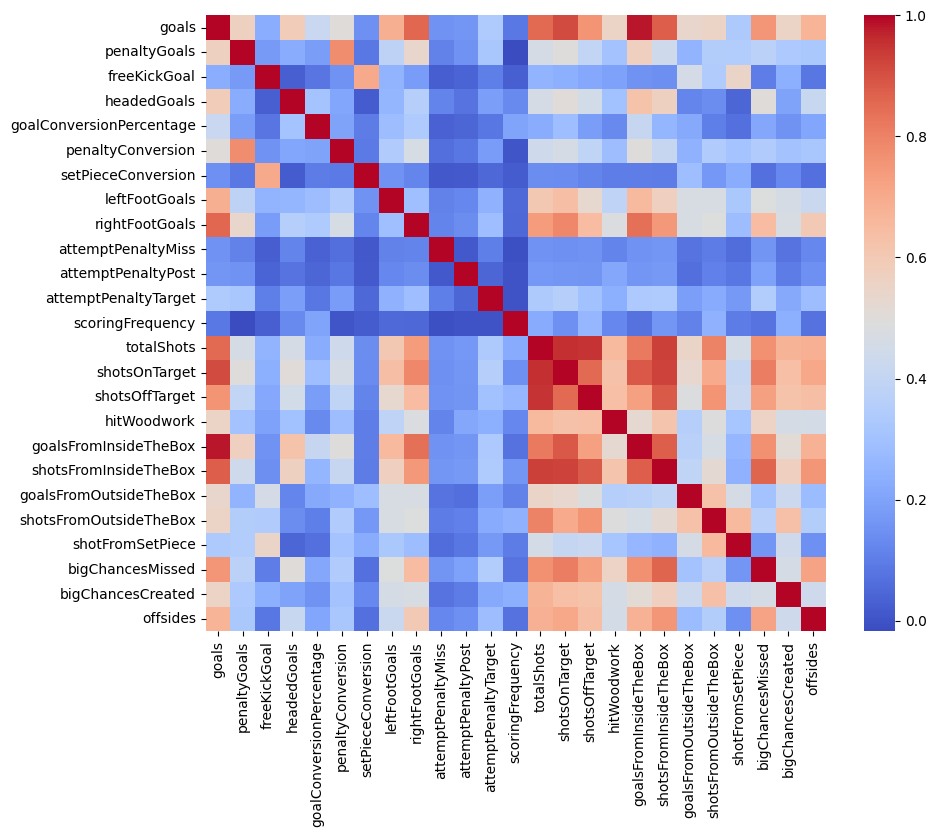

In [43]:
df_chute_corr = df_chute.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(df_chute_corr, cmap='coolwarm')
plt.show()

##### Analisando variáveis de porcentagem

In [47]:
df_statistics[df_statistics['goalConversionPercentage'] == 100][['minutesPlayed', 'matches', 'goals']].describe()

,minutesPlayed,matches,goals
count,65.000000,65.000000,65.000000
mean,233.784615,5.676923,1.015385
std,285.195245,4.667399,0.124035
min,9.000000,1.000000,1.000000
25%,42.000000,2.000000,1.000000
50%,120.000000,4.000000,1.000000
75%,335.000000,9.000000,1.000000
max,1504.000000,20.000000,2.000000


In [49]:
df_statistics[df_statistics['penaltyConversion'] == 100][['minutesPlayed', 'matches', 'penaltyGoals']].describe()

,minutesPlayed,matches,penaltyGoals
count,585.000000,585.000000,585.000000
mean,1746.617094,26.097436,1.769231
std,777.946839,8.417961,1.350955
min,42.000000,2.000000,1.000000
25%,1118.000000,20.000000,1.000000
50%,1783.000000,28.000000,1.000000
75%,2317.000000,32.000000,2.000000
max,3760.000000,46.000000,11.000000


In [51]:
df_statistics[df_statistics['setPieceConversion'] == 100][['minutesPlayed', 'matches', 'freeKickGoal']].describe()

,minutesPlayed,matches,freeKickGoal
count,22.000000,22.000000,22.000000
mean,1208.000000,18.863636,1.045455
std,758.653632,10.143238,0.213201
min,58.000000,2.000000,1.000000
25%,610.000000,12.250000,1.000000
50%,1254.500000,18.500000,1.000000
75%,1656.250000,29.000000,1.000000
max,2536.000000,33.000000,2.000000


##### Entender a escala da scoringFrequency

Observações: Apenas jogadores acima do terceiro quartil possuem gols

In [54]:
df_statistics[df_statistics['scoringFrequency'] == 4089][['goals', 'minutesPlayed']]

,goals,minutesPlayed
10290,1,4089


##### Entender relação de goalsFromInsideTheBox e goalsFromOutsideTheBox. Isso totaliza todos os gols ou não

In [55]:
df_statistics['sum_gols_inside_outside'] = df_statistics['goalsFromInsideTheBox'] + df_statistics['goalsFromOutsideTheBox']

In [56]:
df_statistics[df_statistics['goals'] > 1][['goals', 'goalsFromInsideTheBox', 'goalsFromOutsideTheBox', 'sum_gols_inside_outside']].head(10)

,goals,goalsFromInsideTheBox,goalsFromOutsideTheBox,sum_gols_inside_outside
0,3,3,0,3
2,2,2,0,2
3,2,2,0,2
7,2,1,1,2
12,2,2,0,2
16,2,2,0,2
18,2,2,0,2
19,2,2,0,2
21,4,4,0,4
23,3,2,1,3


##### Analisando totalShots

- Faz sentido. o Messi deu 104 chutes na temporada 2024.

In [59]:
df_statistics[df_statistics['totalShots'] == 167.000000][['name', 'tournament']]

,name,tournament
10648,Morgan Whittaker,championship
19878,Denis Bouanga,mls


In [65]:
df_statistics[df_statistics['name'] == 'Lionel Messi'][['goalConversionPercentage', 'totalShots']]

,goalConversionPercentage,totalShots
20091,20.192308,104


##### Analisando impedimentos

In [67]:
df_statistics[df_statistics['offsides'] == 43]

,positive,negative,positions,heatmap,matches,season,tournament,name,position,height,preferredFoot,proposedMarketValue,contractUntilTimestamp,current_team,current_team_tournament,current_team_tournament_category,current_team_country,player_id,retired,deceased,season_team,season_team_shortname,rating,totalRating,countRating,goals,bigChancesCreated,bigChancesMissed,assists,goalsAssistsSum,accuratePasses,inaccuratePasses,totalPasses,accuratePassesPercentage,accurateOwnHalfPasses,accurateOppositionHalfPasses,accurateFinalThirdPasses,keyPasses,successfulDribbles,successfulDribblesPercentage,tackles,interceptions,yellowCards,directRedCards,redCards,accurateCrosses,accurateCrossesPercentage,totalShots,shotsOnTarget,shotsOffTarget,groundDuelsWon,groundDuelsWonPercentage,aerialDuelsWon,aerialDuelsWonPercentage,totalDuelsWon,totalDuelsWonPercentage,minutesPlayed,goalConversionPercentage,penaltiesTaken,penaltyGoals,penaltyWon,penaltyConceded,shotFromSetPiece,freeKickGoal,goalsFromInsideTheBox,goalsFromOutsideTheBox,shotsFromInsideTheBox,shotsFromOutsideTheBox,headedGoals,leftFootGoals,rightFootGoals,accurateLongBalls,accurateLongBallsPercentage,clearances,errorLeadToGoal,errorLeadToShot,dispossessed,possessionLost,possessionWonAttThird,totalChippedPasses,accurateChippedPasses,touches,wasFouled,fouls,hitWoodwork,ownGoals,dribbledPast,offsides,blockedShots,passToAssist,saves,cleanSheet,penaltyFaced,penaltySave,savedShotsFromInsideTheBox,savedShotsFromOutsideTheBox,goalsConcededInsideTheBox,goalsConcededOutsideTheBox,punches,runsOut,successfulRunsOut,highClaims,crossesNotClaimed,matchesStarted,penaltyConversion,setPieceConversion,totalAttemptAssist,totalContest,totalCross,duelLost,aerialLost,attemptPenaltyMiss,attemptPenaltyPost,attemptPenaltyTarget,totalLongBalls,goalsConceded,tacklesWon,tacklesWonPercentage,scoringFrequency,yellowRedCards,savesCaught,savesParried,totalOwnHalfPasses,totalOppositionHalfPasses,totwAppearances,goalKicks,ballRecovery,id,type,appearances,goalsPrevented,expectedAssists,expectedGoals,age,sum_gols_inside_outside
10339,[],"[{'type': 14, 'rank': 3339}]",['AM'],"[{'x': 50, 'y': 50, 'count': 26}, {'x': 50, 'y...",44.0,23_24,championship,Sammie Szmodics,M,168.0,Right,11200000.0,1.845936e+09,Ipswich,League One,England,England,354782,NaN,False,Blackburn Rovers,Blackburn,7.318182,322.0,44,27,7,17,4.0,31,1056,252,1308,80.733945,342,723,499,49,30,49.180328,29,17,8,0,0.0,9,11.538462,145,60,47,101,42.978723,7,30.434783,108,41.860465,3905,18.62069,1,0.0,0,0,3,0,23,4,100,45,2,3,22,64,61.538462,14,1,0,48,507,22,79,42,1962,42,21,2,0.0,34,43,38,0,0,6,0,0,0,0,58,7,0,0,0,0,0,44,0.0,0.0,49,61,78,150,16,0,1,0,104,65,19,65.517241,144.62963,0.0,0,0,388,998,6,0.0,127.0,1059243,overall,44,0.0,3.716526,22.3608,29.0,27


#### Estatísticas relacionadas a drible

- Vou utilizar o número de dribles invés da porcentagem pois tem goleiros com 100% de acerto em drible, isso não quer dizer que ele é um bom driblador
- Os outliers na variável successfulDribbles parecem normais. Dentre os defensores que tem um número mais alto de acerto em drible, são jogadores que atuam mais como laterais.

In [389]:
df_drible = df_statistics[[
    'matches',
    'successfulDribbles',
    'successfulDribblesPercentage', # vou usar essa aqui
]]

In [265]:
df_drible.describe()

,matches,successfulDribbles,successfulDribblesPercentage
count,11364.000000,11364.000000,11364.000000
mean,17.904699,9.003432,43.432362
std,11.274794,12.309457,28.974247
min,1.000000,0.000000,0.000000
25%,8.000000,1.000000,25.000000
50%,18.000000,4.000000,47.058824
75%,28.000000,12.000000,60.000000
max,46.000000,148.000000,100.000000


In [390]:
grouped_data = df_statistics[df_statistics['successfulDribblesPercentage'] == 100].groupby('position')['successfulDribblesPercentage'].count().reset_index().sort_values('successfulDribblesPercentage')

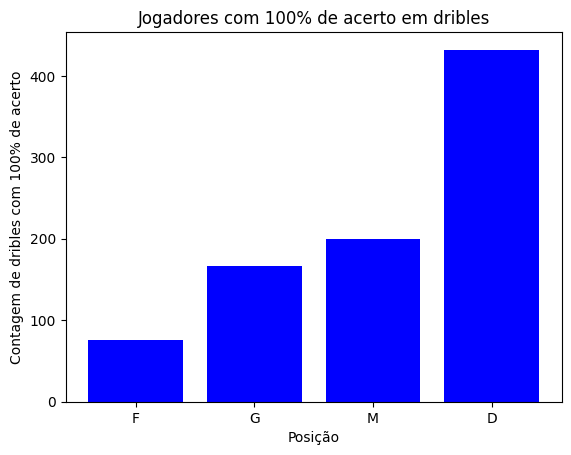

In [391]:
generic_bar_graph(grouped_data['position'], values=grouped_data['successfulDribblesPercentage'], x_label='Posição', y_label='Contagem de dribles com 100% de acerto', title='Jogadores com 100% de acerto em dribles')

In [392]:
grouped_data = df_statistics.groupby('position')['successfulDribbles'].sum().reset_index().sort_values('successfulDribbles')

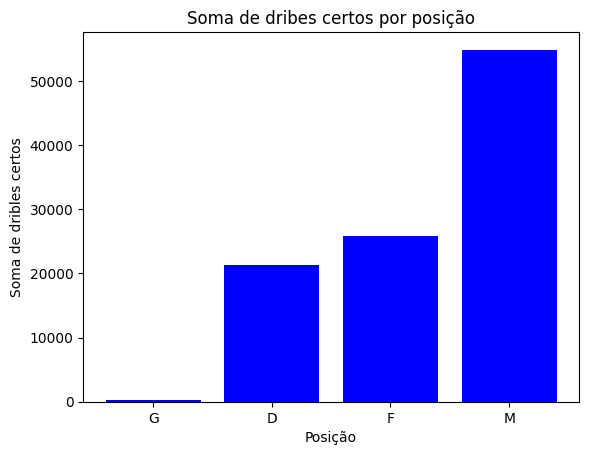

In [393]:
generic_bar_graph(grouped_data['position'], values=grouped_data['successfulDribbles'], x_label='Posição', y_label='Soma de dribles certos', title='Soma de dribes certos por posição')

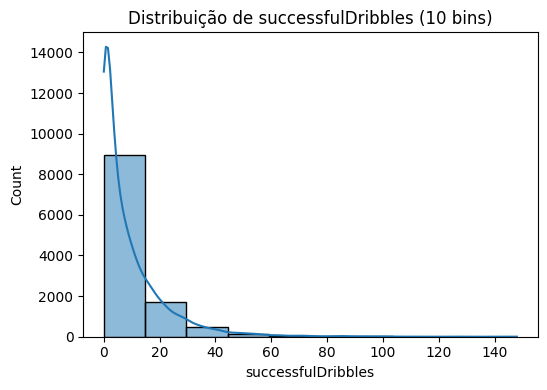

In [394]:
generic_distribution_plot(df_drible, ['successfulDribbles'])

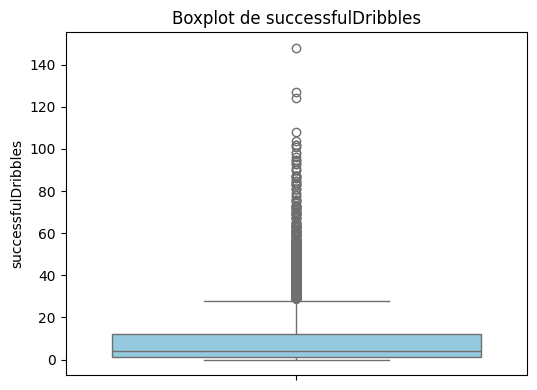

In [266]:
generic_plot_boxplots(df_drible, ['successfulDribbles'])

In [257]:
df_drible_quartis = df_drible.sort_values('successfulDribbles').reset_index()

In [284]:
df_drible_quartis[df_drible_quartis.index < 2841].groupby(['successfulDribbles', 'matches']).count()

index  successfulDribblesPercentage
successfulDribbles matches                                     
0                  1.0        694                           694
                   2.0        332                           332
                   3.0        217                           217
                   4.0        149                           149
                   5.0        118                           118
                   6.0         93                            93
                   7.0         88                            88
                   8.0         71                            71
                   9.0         57                            57
                   10.0        57                            57
                   11.0        47                            47
                   12.0        37                            37
                   13.0        40                            40
                   14.0        37                            37
                   15.0        38                            38
                   16.0        27                            27
                   17.0        32                            32
                   18.0        20                            20
                   19.0        18                            18
                   20.0        20                            20
                   21.0        17                            17
                   22.0         8                             8
                   23.0        16                            16
                   24.0        10                            10
                   25.0        14                            14
                   26.0        20                            20
                   27.0        21                            21
                   28.0        12                            12
                   29.0        11                            11
                   30.0        10                            10
                   31.0        14                            14
                   32.0        15                            15
                   33.0        23                            23
                   34.0        19                            19
                   35.0         5                             5
                   36.0         9                             9
                   37.0        15                            15
                   38.0         7                             7
                   39.0         1                             1
                   40.0         2                             2
                   41.0         1                             1
                   44.0         3                             3
                   45.0         1                             1
                   46.0         1                             1
1                  1.0         24                            24
                   2.0         24                            24
                   3.0         25                            25
                   4.0         29                            29
                   5.0         25                            25
                   6.0         26                            26
                   7.0         20                            20
                   8.0         17                            17
                   9.0         18                            18
                   10.0        17                            17
                   11.0        17                            17
                   12.0        13                            13
                   13.0        13                            13
                   14.0         7                             7
                   15.0        13                            13
                   16.0         8                             8
                   17.0         2                           

In [258]:
len(df_drible_quartis)

11364

In [273]:
# Calcular Q1, Q3 e IQR
Q1 = df_analisys['successfulDribbles'].quantile(0.25)
Q3 = df_analisys['successfulDribbles'].quantile(0.75)
IQR = Q3 - Q1

# Definir limites para outliers
limite_inferior = Q1 - 1.5 * IQR
limite_superior = Q3 + 1.5 * IQR

# Filtrar apenas os outliers
outliers = df_analisys[(df_analisys['successfulDribbles'] < limite_inferior) | 
              (df_analisys['successfulDribbles'] > limite_superior)]

In [277]:
grouped_data = outliers.groupby('position')['successfulDribbles'].count().reset_index()

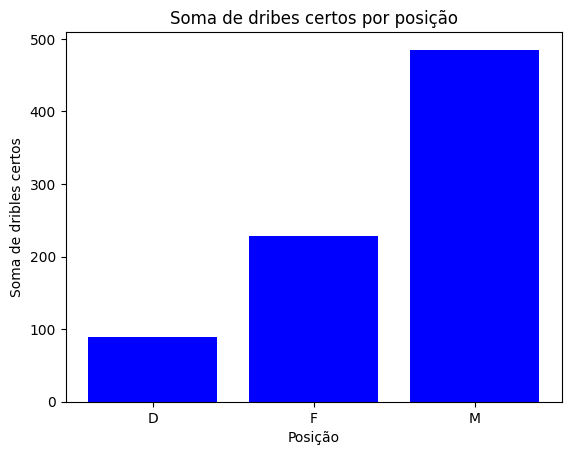

In [278]:
generic_bar_graph(grouped_data['position'], values=grouped_data['successfulDribbles'], x_label='Posição', y_label='Soma de dribles certos', title='Soma de dribes certos por posição')

In [282]:
outliers[outliers['position'] == 'D'][['name', 'successfulDribbles']].sort_values('successfulDribbles', ascending=False).head(10)

,name,successfulDribbles
10586,Kyle Walker-Peters,83
14290,Alphonso Davies,70
10466,Callum Brittain,69
15266,Rodrigo Conceição,60
21037,João Cancelo,60
175,Tymoteusz Puchacz,58
12785,Ferdi Kadıoğlu,57
11692,Bradley Locko,56
19656,Joseph Rosales,56
15199,Isaac Schmidt,54


In [283]:
outliers[outliers['position'] == 'D'][['name', 'successfulDribbles']].sort_values('successfulDribbles', ascending=True).head(10)

,name,successfulDribbles
7900,Alan Mozo,29
6774,Martín Ortega,29
9245,João Lucas,29
9730,Elias Jelert,29
12082,Christopher Operi,29
10738,Akin Famewo,29
11581,Wilfried Singo,29
10612,Jay Dasilva,29
14368,Kevin Mbabu,29
12897,Taha Şahin,29


#### Estatísticas relacionadas a passe ou assistencia


- goalsAssistsSum: repetitivo, soma de todos os gols e assistencias que o jogador fez na temporada. Não vale muito apena usar
- KeyPasses e totalAttemptAssist tem praticamente a mesma distribuição
- Da para perceber que as variáveis totais juntas com as de acurácia se correlacionam em alguns casos, e faz sentido isso existir
- Entre o quartil 75% e maximo, existe um salto gigantesco nos valores

In [395]:
df_passe = df_statistics[[
    'matches',
    'assists',
    'goalsAssistsSum',
    'accuratePasses',
    'inaccuratePasses', 
    'totalPasses',
    'accuratePassesPercentage',
    'accurateOwnHalfPasses',
    'accurateOppositionHalfPasses', 
    'accurateFinalThirdPasses',
    'keyPasses',
    'accurateCrosses',
    'accurateCrossesPercentage',
    'accurateLongBalls',
    'accurateLongBallsPercentage',
    'passToAssist',
    'totalCross',
    'totalLongBalls',
    'totalOwnHalfPasses',
    'totalOppositionHalfPasses',
    'expectedAssists',
    'totalChippedPasses',
    'accurateChippedPasses',
    'totalAttemptAssist',
]].copy()

##### Descrição das variáveis

In [397]:
df_passe.describe()

,matches,assists,goalsAssistsSum,accuratePasses,inaccuratePasses,totalPasses,accuratePassesPercentage,accurateOwnHalfPasses,accurateOppositionHalfPasses,accurateFinalThirdPasses,keyPasses,accurateCrosses,accurateCrossesPercentage,accurateLongBalls,accurateLongBallsPercentage,passToAssist,totalCross,totalLongBalls,totalOwnHalfPasses,totalOppositionHalfPasses,expectedAssists,totalChippedPasses,accurateChippedPasses,totalAttemptAssist
count,11362.000000,11362.000000,11362.000000,11362.000000,11362.000000,11362.000000,11362.000000,11362.000000,11362.000000,11362.000000,11362.000000,11362.000000,11362.000000,11362.000000,11362.000000,11362.000000,11362.000000,11362.000000,11362.000000,11362.000000,11362.000000,11362.000000,11362.000000,11362.000000
mean,17.907499,1.090213,2.661503,407.195300,96.965587,504.160887,77.192150,215.145309,197.232265,93.281465,11.293170,5.182274,17.077726,30.654814,44.377574,0.095582,21.063633,66.241243,242.209822,283.014698,0.757788,38.982309,19.601127,11.197588
std,11.273804,1.816184,4.178170,432.356791,89.740348,504.690995,12.532733,266.364996,207.646209,103.872228,14.616497,9.834604,19.571287,44.033457,22.702333,0.393616,35.494734,100.703907,289.236270,272.901053,1.411359,47.598687,24.845999,14.461308
min,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,8.000000,0.000000,0.000000,78.000000,24.000000,105.000000,72.333702,31.000000,38.000000,16.000000,1.000000,0.000000,0.000000,3.000000,33.333333,0.000000,1.000000,7.000000,38.000000,64.000000,0.000000,5.000000,2.000000,1.000000
50%,18.000000,0.000000,1.000000,269.500000,74.000000,354.500000,79.202721,114.000000,131.000000,59.000000,6.000000,1.000000,15.384615,14.000000,45.757173,0.000000,6.000000,30.000000,134.000000,210.000000,0.080191,21.000000,10.000000,6.000000
75%,28.000000,2.000000,4.000000,603.000000,146.750000,765.000000,84.615385,307.000000,289.000000,135.000000,16.000000,6.000000,27.272727,41.000000,57.291667,0.000000,25.000000,86.000000,350.000000,419.000000,0.937880,56.000000,28.000000,16.000000
max,46.000000,18.000000,44.000000,3832.000000,883.000000,4155.000000,100.000000,2590.000000,2122.000000,1019.000000,127.000000,148.000000,100.000000,565.000000,100.000000,8.000000,474.000000,1444.000000,2736.000000,2342.000000,15.595675,449.000000,265.000000,127.000000


##### Análise de correlação das variáveis

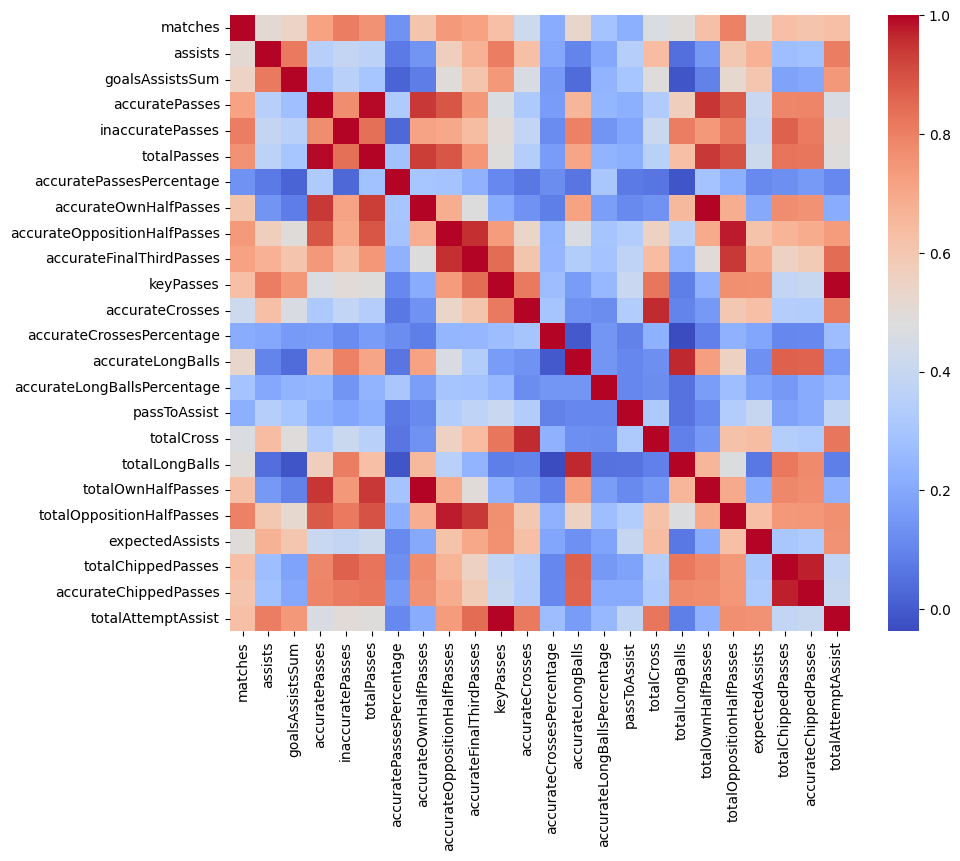

In [396]:
df_passe_corr = df_passe.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(df_passe_corr, cmap='coolwarm')
plt.show()

##### Analisando quem tem 100% de acurácia em passes

In [398]:
df_statistics[
    (df_statistics['accuratePassesPercentage'] == 100)
][['matches', 'minutesPlayed', 'accuratePassesPercentage','totalPasses', 'accuratePasses']].describe()

,matches,minutesPlayed,accuratePassesPercentage,totalPasses,accuratePasses
count,268.000000,268.000000,268.0,268.000000,268.000000
mean,1.335821,13.742537,100.0,3.936567,3.936567
std,0.778398,14.308170,0.0,3.832603,3.832603
min,1.000000,1.000000,100.0,1.000000,1.000000
25%,1.000000,8.000000,100.0,1.000000,1.000000
50%,1.000000,10.000000,100.0,3.000000,3.000000
75%,1.000000,15.250000,100.0,5.000000,5.000000
max,6.000000,90.000000,100.0,32.000000,32.000000


In [399]:
df_statistics[
    (df_statistics['accurateCrossesPercentage'] == 100)
][['matches', 'minutesPlayed', 'accurateCrossesPercentage', 'totalCross', 'accurateCrosses']].describe()

,matches,minutesPlayed,accurateCrossesPercentage,totalCross,accurateCrosses
count,222.000000,222.000000,222.0,222.000000,222.000000
mean,11.608108,676.608108,100.0,1.202703,1.202703
std,9.191996,759.824994,0.0,0.511755,0.511755
min,1.000000,1.000000,100.0,1.000000,1.000000
25%,4.000000,104.250000,100.0,1.000000,1.000000
50%,9.000000,346.000000,100.0,1.000000,1.000000
75%,17.750000,986.750000,100.0,1.000000,1.000000
max,41.000000,3510.000000,100.0,4.000000,4.000000


In [400]:
df_statistics[(df_statistics['accurateCrossesPercentage'] == 100)].sort_values('matches', ascending=False)[[
    'matches', 'position', 'minutesPlayed', 'accurateCrossesPercentage','totalPasses', 'accuratePasses', 'totalCross', 'accurateCrosses',
]]

,matches,position,minutesPlayed,accurateCrossesPercentage,totalPasses,accuratePasses,totalCross,accurateCrosses
10289,41.0,D,3510,100.0,2594,2209,2,2
15202,37.0,D,3198,100.0,1639,1370,2,2
10407,35.0,D,2876,100.0,2158,1888,1,1
20253,35.0,D,3149,100.0,2202,1964,1,1
1286,35.0,D,3117,100.0,1371,1098,1,1
...,...,...,...,...,...,...,...,...
18031,1.0,D,10,100.0,8,6,1,1
16072,1.0,M,26,100.0,9,9,1,1
20252,1.0,F,10,100.0,7,5,1,1
16900,1.0,D,11,100.0,9,7,1,1


In [401]:
df_statistics[
    (df_statistics['accurateLongBallsPercentage'] == 100)
][['matches', 'minutesPlayed', 'accurateLongBallsPercentage', 'totalLongBalls', 'accurateLongBalls']].describe()

,matches,minutesPlayed,accurateLongBallsPercentage,totalLongBalls,accurateLongBalls
count,375.000000,375.000000,375.0,375.000000,375.000000
mean,6.896000,229.688000,100.0,1.986667,1.986667
std,6.618105,328.530639,0.0,1.840522,1.840522
min,1.000000,1.000000,100.0,1.000000,1.000000
25%,2.000000,45.000000,100.0,1.000000,1.000000
50%,4.000000,120.000000,100.0,1.000000,1.000000
75%,10.000000,276.500000,100.0,2.000000,2.000000
max,36.000000,2605.000000,100.0,14.000000,14.000000


In [402]:
df_statistics[(df_statistics['accurateLongBallsPercentage'] == 100)].sort_values('matches', ascending=False)[[
    'matches', 'minutesPlayed', 'position', 'minutesPlayed', 'totalLongBalls', 'accurateLongBalls'
]]

,matches,minutesPlayed,position,minutesPlayed,totalLongBalls,accurateLongBalls
20926,36.0,2605,F,2605,4,4
2274,36.0,2142,F,2142,7,7
10676,33.0,1500,M,1500,7,7
1135,30.0,2169,F,2169,9,9
10330,30.0,953,F,953,3,3
...,...,...,...,...,...,...
7964,1.0,56,M,56,1,1
1291,1.0,31,D,31,1,1
1339,1.0,32,F,32,1,1
2157,1.0,45,M,45,1,1


In [403]:
df_statistics[df_statistics['minutesPlayed'] > 90][['totalPasses', 'accuratePasses', 'accuratePassesPercentage']].describe()

,totalPasses,accuratePasses,accuratePassesPercentage
count,9858.000000,9858.000000,9858.000000
mean,578.869040,467.604687,77.961750
std,501.376141,433.429772,8.663576
min,9.000000,5.000000,21.739130
25%,187.000000,141.000000,73.012491
50%,440.000000,340.000000,79.268293
75%,839.000000,673.000000,84.268095
max,4155.000000,3832.000000,96.551724


##### Analisando outliers em variáveis totais de passe

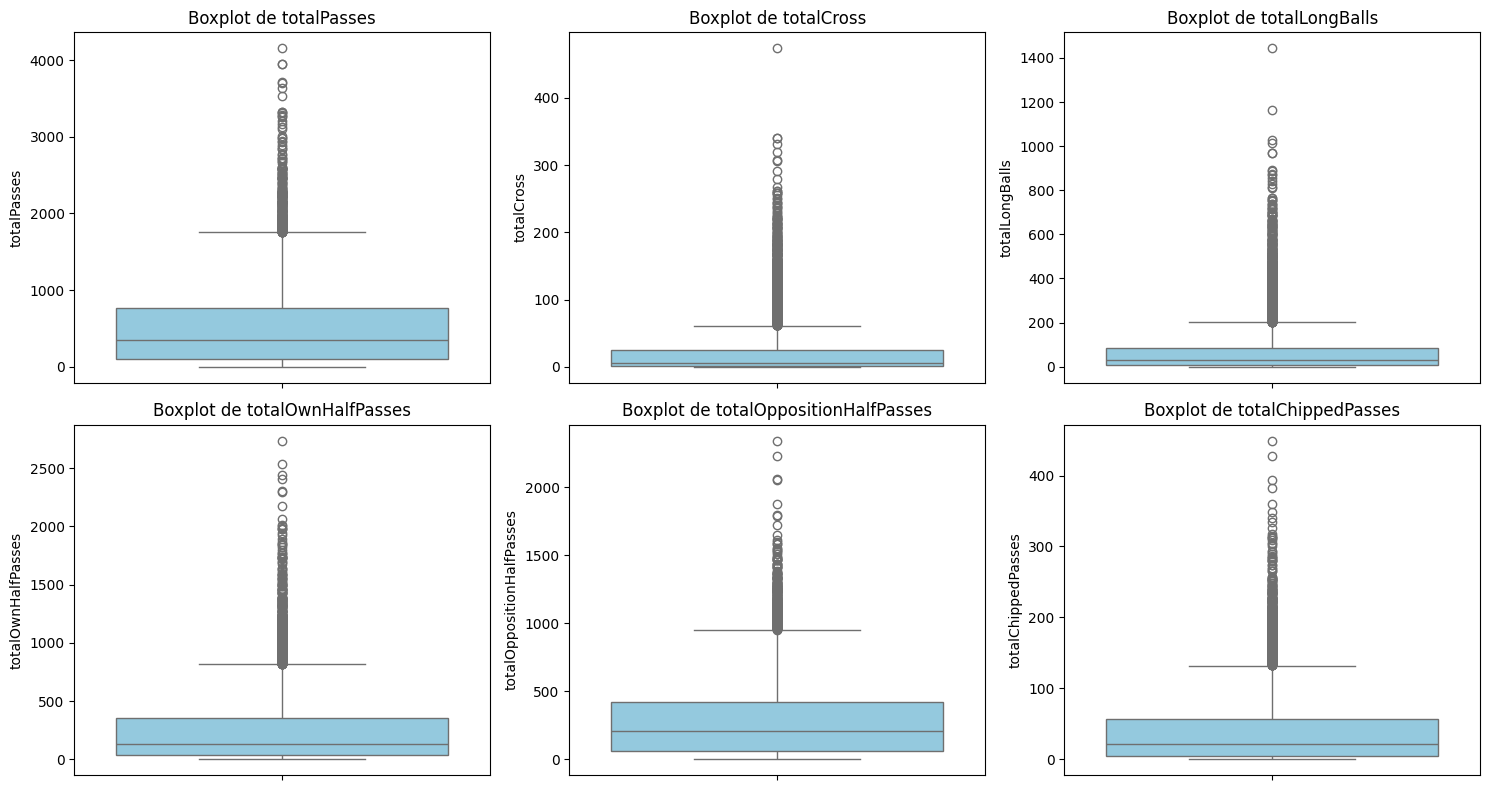

In [404]:
generic_plot_boxplots(df_statistics, ['totalPasses', 'totalCross', 'totalLongBalls', 'totalOwnHalfPasses', 'totalOppositionHalfPasses', 'totalChippedPasses'])

In [405]:
df_statistics[['name', 'player_id', 'tournament','position','matches','minutesPlayed', 'totalLongBalls']].sort_values('totalLongBalls')

,name,player_id,tournament,position,matches,minutesPlayed,totalLongBalls
6971,Marcos Montiel,975819,liga_profesional_de_futbol,M,1.0,25,0
13255,Göktan Gürpüz,997007,trendyol_super_lig,M,5.0,39,0
19868,Rory O'Driscoll,1847627,mls,M,1.0,1,0
19867,Mykhi Joyner,1393586,mls,M,1.0,45,0
4653,Alex Cetnar,1652452,ekstraklasa,M,1.0,1,0
...,...,...,...,...,...,...,...
20636,David Soria,604258,laliga,G,38.0,3414,968
22024,Warleson,861071,pro_league,G,40.0,3600,1016
10176,Freddie Woodman,284417,championship,G,44.0,3960,1028
14198,Manuel Riemann,24937,bundesliga,G,33.0,2970,1166


In [406]:
df_statistics[['name', 'player_id', 'tournament','position','matches','minutesPlayed', 'totalPasses']].sort_values('totalPasses')

,name,player_id,tournament,position,matches,minutesPlayed,totalPasses
424,Eric da Silva Moreira,1418646,2_bundesliga,M,1.0,1,0
9375,Kayke Ayrton,1882403,brasileirao_betano,F,1.0,2,0
6213,Santiago Martinez,1937594,liga_profesional_de_futbol,M,1.0,15,0
6210,Matías Gómez,1507306,liga_profesional_de_futbol,M,1.0,1,0
14309,Jonathan Asp Jensen,1146545,bundesliga,M,1.0,1,0
...,...,...,...,...,...,...,...
10156,Taylor Harwood-Bellis,980637,championship,D,40.0,3501,3701
10286,Matt Grimes,340713,championship,M,46.0,4140,3714
10560,Harry Winks,545780,championship,M,45.0,4041,3946
10536,Jan Bednarek,286085,championship,D,42.0,3547,3947


In [407]:
df_index_reseted = df_statistics.reset_index()

In [324]:
grouped_data = df_index_reseted[df_index_reseted.index > 8530].groupby('position')['totalLongBalls'].sum().reset_index().sort_values('totalLongBalls')

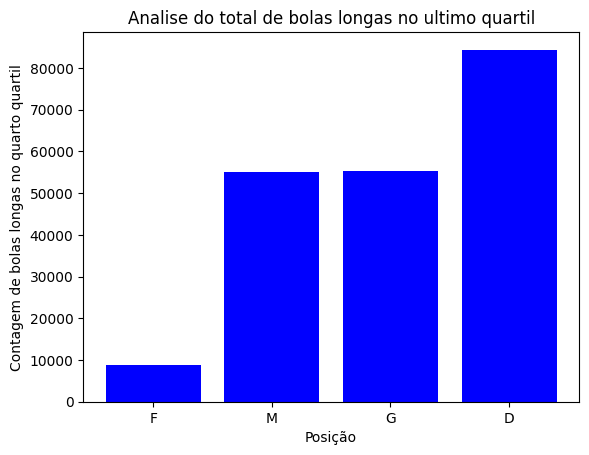

In [325]:
generic_bar_graph(grouped_data['position'], grouped_data['totalLongBalls'], x_label='Posição', y_label='Contagem de bolas longas no quarto quartil', title='Analise do total de bolas longas no ultimo quartil')

#### Estatísticas relacionadas a marcação

- ownGoals é bem raro. Ver se tem algum sentido
- goalsConceded: São quantos gols o time tomou equanto o jogador estava em campo. Para jogadores de ataque pode penalizar demais, para goleiros e zagueiros é uma boa feature
- Segue o mesmo padrão das características de passe. O ultimo quartil tem muitos "outliers" comparados aos outros, variáveis de percentil são afetadas por poucos jogos

In [ ]:
df_marcacao =  df_statistics[[
    'matches',
    'minutesPlayed',
    'tackles',
    'interceptions',
    'groundDuelsWon',
    'groundDuelsWonPercentage',
    'aerialDuelsWon',
    'aerialDuelsWonPercentage',
    'totalDuelsWon',
    'totalDuelsWonPercentage',
    'clearances',
    'errorLeadToGoal',
    'errorLeadToShot',
    'possessionLost',
    'possessionWonAttThird',
    'ownGoals',
    'dribbledPast', # foi driblado
    'blockedShots', 
    'duelLost',
    'aerialLost',
    'goalsConceded',
    'tacklesWon',
    'tacklesWonPercentage',
    'ballRecovery',
    'dispossessed',
]].copy()

##### Descrição das variáveis

In [431]:
df_marcacao.describe()

,matches,minutesPlayed,tackles,interceptions,groundDuelsWon,groundDuelsWonPercentage,aerialDuelsWon,aerialDuelsWonPercentage,totalDuelsWon,totalDuelsWonPercentage,clearances,errorLeadToGoal,errorLeadToShot,possessionLost,possessionWonAttThird,ownGoals,dribbledPast,blockedShots,duelLost,aerialLost,goalsConceded,tacklesWon,tacklesWonPercentage,ballRecovery
count,11362.000000,11362.000000,11362.000000,11362.000000,11362.000000,11362.000000,11362.000000,11362.000000,11362.000000,11362.000000,11362.000000,11362.000000,11362.000000,11362.000000,11362.000000,11362.000000,11362.000000,11362.000000,11362.000000,11362.000000,11362.000000,11362.000000,11362.000000,11362.000000
mean,17.907499,1155.746876,18.772839,10.267206,40.876606,48.371142,16.985038,44.505866,57.861644,49.478673,22.200493,0.135540,0.206566,157.305580,4.707358,0.043302,9.003521,3.976501,57.857067,16.984422,17.660535,11.677258,53.900306,62.732353
std,11.273804,933.925783,19.504609,12.242161,39.516637,19.055823,22.089597,25.080627,52.592802,17.923049,30.082753,0.429859,0.532062,136.019466,6.114680,0.220165,9.804676,5.395238,53.071795,19.334373,14.967793,12.325363,28.351891,61.976224
min,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,8.000000,309.250000,3.000000,1.000000,8.000000,41.574512,3.000000,30.952381,12.000000,42.105263,3.000000,0.000000,0.000000,42.000000,0.000000,0.000000,1.000000,0.000000,12.000000,3.000000,5.000000,2.000000,46.875000,14.000000
50%,18.000000,989.500000,13.000000,6.000000,30.000000,50.000000,9.000000,46.153846,45.000000,50.000000,11.000000,0.000000,0.000000,128.000000,2.000000,0.000000,6.000000,2.000000,46.000000,12.000000,14.000000,8.000000,60.000000,46.000000
75%,28.000000,1858.500000,29.000000,16.000000,63.000000,56.942783,23.000000,58.823529,91.000000,57.000000,29.000000,0.000000,0.000000,241.000000,7.000000,0.000000,13.000000,6.000000,89.000000,24.750000,27.000000,18.000000,70.000000,94.000000
max,46.000000,4140.000000,152.000000,81.000000,304.000000,100.000000,314.000000,100.000000,364.000000,100.000000,251.000000,6.000000,5.000000,903.000000,59.000000,3.000000,80.000000,59.000000,450.000000,248.000000,89.000000,97.000000,100.000000,456.000000


##### Analisando correlação entre variáveis

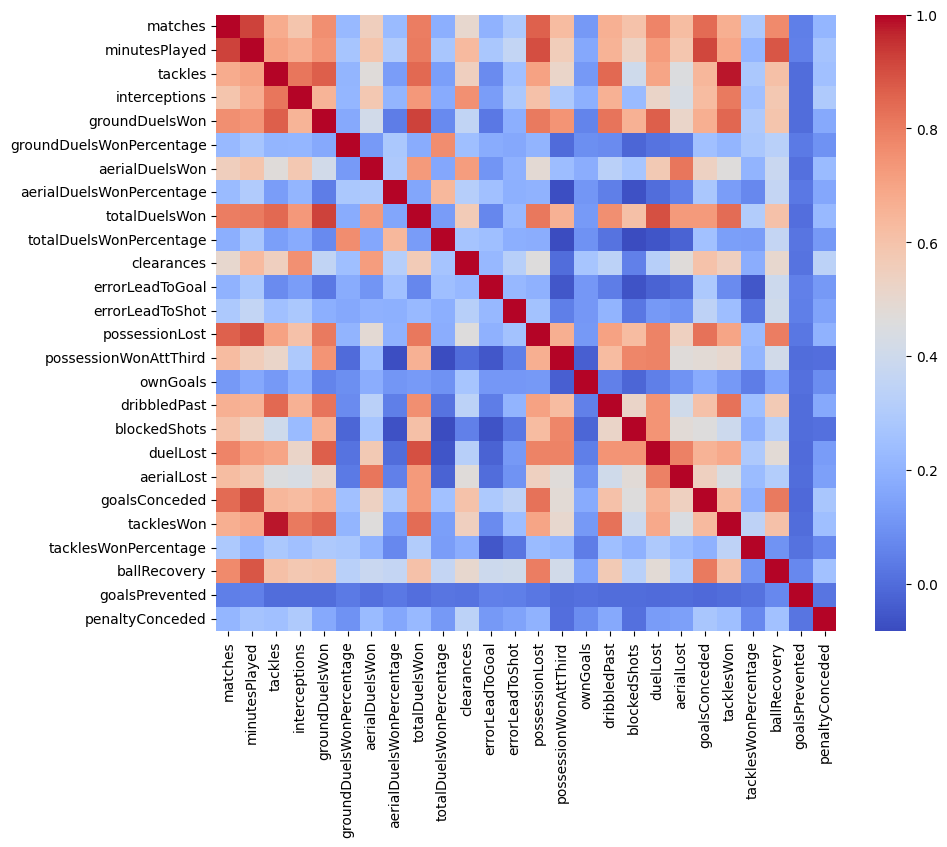

In [409]:
df_marcacao_corr = df_marcacao.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(df_marcacao_corr, cmap='coolwarm')
plt.show()

##### Analisando variáveis de porcentagem

In [412]:
df_statistics[df_statistics['groundDuelsWonPercentage'] == 100][['matches', 'minutesPlayed', 'groundDuelsWon']].describe()

,matches,minutesPlayed,groundDuelsWon
count,391.000000,391.000000,391.000000
mean,9.516624,789.235294,2.332481
std,11.096967,1038.244043,1.856919
min,1.000000,1.000000,1.000000
25%,1.000000,20.000000,1.000000
50%,4.000000,180.000000,2.000000
75%,16.000000,1397.500000,3.000000
max,46.000000,4140.000000,11.000000


In [414]:
df_statistics[df_statistics['aerialDuelsWonPercentage'] == 100][['matches', 'minutesPlayed', 'groundDuelsWon']].describe()

,matches,minutesPlayed,groundDuelsWon
count,651.000000,651.000000,651.000000
mean,11.536098,939.513057,3.221198
std,11.408088,1079.100741,4.606709
min,1.000000,1.000000,0.000000
25%,2.000000,81.000000,1.000000
50%,7.000000,398.000000,2.000000
75%,18.500000,1629.500000,4.000000
max,45.000000,4050.000000,54.000000


In [415]:
df_statistics[df_statistics['totalDuelsWonPercentage'] == 100][['matches', 'minutesPlayed', 'groundDuelsWon']].describe()

,matches,minutesPlayed,groundDuelsWon
count,352.000000,352.000000,352.000000
mean,7.184659,593.147727,1.519886
std,8.972417,832.319507,1.658837
min,1.000000,1.000000,0.000000
25%,1.000000,22.000000,0.000000
50%,3.000000,230.000000,1.000000
75%,9.000000,810.000000,2.000000
max,41.000000,3690.000000,9.000000


In [416]:
df_statistics[df_statistics['tacklesWonPercentage'] == 100][['matches', 'minutesPlayed', 'groundDuelsWon']].describe()

,matches,minutesPlayed,groundDuelsWon
count,866.000000,866.000000,866.000000
mean,9.167436,498.841801,7.351039
std,9.138543,795.983897,8.135364
min,1.000000,1.000000,1.000000
25%,3.000000,61.250000,2.000000
50%,6.000000,174.500000,5.000000
75%,12.000000,475.250000,10.000000
max,46.000000,4139.000000,85.000000


##### Analisando errorLeadToGoal e errorLeadToShot

- São eventos bem raros no dataset, mas olhando para quando ocorre um erro, todas as posições tem algo em comum. Teria que entender como tornar isso uma penalidade

In [423]:
grouped_data = df_statistics[df_statistics['errorLeadToGoal'] > 0].groupby('position')['errorLeadToGoal'].count().reset_index()

In [424]:
grouped_data

,position,errorLeadToGoal
0,D,552
1,F,29
2,G,357
3,M,317


In [425]:
grouped_data = df_statistics[df_statistics['errorLeadToShot'] > 0].groupby('position')['errorLeadToShot'].count().reset_index()

In [426]:
grouped_data

,position,errorLeadToShot
0,D,827
1,F,85
2,G,266
3,M,638


##### Analisando goalsConceded

In [437]:
df_statistics[(df_statistics['goalsConceded'] > 40) & (df_statistics['season_team'] == 'SV 07 Elversberg')][['name', 'position','tournament', 'season_team', 'goalsConceded']]

,name,position,tournament,season_team,goalsConceded
0,Manuel Feil,M,2_bundesliga,SV 07 Elversberg,44
2,Carlo Sickinger,M,2_bundesliga,SV 07 Elversberg,43
101,Nicolas Kristof,G,2_bundesliga,SV 07 Elversberg,60
222,Jannik Rochelt,M,2_bundesliga,SV 07 Elversberg,54
227,Maurice Neubauer,D,2_bundesliga,SV 07 Elversberg,56
430,Robin Fellhauer,M,2_bundesliga,SV 07 Elversberg,54


In [442]:
grouped_data = df_statistics[df_statistics['goalsConceded'] > 0].groupby('position')['goalsConceded'].sum().reset_index().sort_values('goalsConceded')

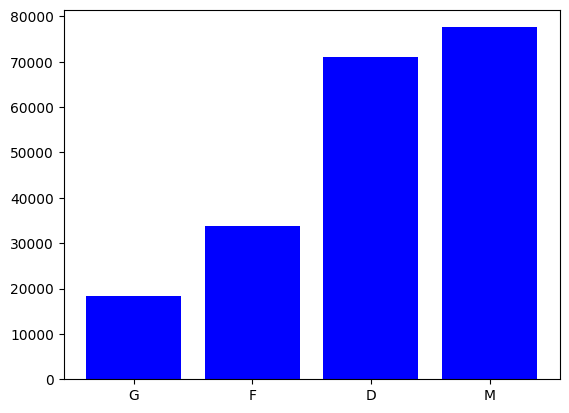

In [443]:
generic_bar_graph(grouped_data['position'], grouped_data['goalsConceded'], x_label='', y_label='', title='')

In [444]:
grouped_data = df_statistics.groupby('position').count()

#### Estatísticas relacionadas a problemas disciplinares

- penaltyConceded é o número de penaltis que o jogador fez

In [452]:
df_disciplina = df_statistics[[
    'yellowCards',
    'directRedCards',
    'redCards',
    'fouls', 
    'yellowRedCards',
    'penaltyConceded',
]]

##### Descrição dos dados

In [455]:
df_disciplina.describe()

,yellowCards,directRedCards,redCards,fouls,yellowRedCards,penaltyConceded
count,11362.000000,11362.000000,11362.000000,11362.000000,11362.000000,11362.000000
mean,2.483102,0.072170,0.126298,14.086780,0.054128,0.175145
std,2.543162,0.273016,0.366467,13.441356,0.239140,0.456877
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,3.000000,0.000000,0.000000
50%,2.000000,0.000000,0.000000,11.000000,0.000000,0.000000
75%,4.000000,0.000000,0.000000,22.000000,0.000000,0.000000
max,17.000000,3.000000,3.000000,91.000000,3.000000,5.000000


##### Analisando faltas

In [454]:
df_analisys[df_analisys['fouls'] == 91][['name', 'position', 'fouls']]

,name,position,fouls
8960,Gregore,M,91


##### Analisando penaltyConceded

In [462]:
df_analisys[df_analisys['season_team'].str.contains('Grêmio')]['penaltyConceded'].sum()

np.int64(10)

In [461]:
df_analisys[df_analisys['season_team'].str.contains('Grêmio')][['name', 'penaltyConceded']]

,name,penaltyConceded
8735,Rodrigo Caio,1
8798,Yeferson Soteldo,0
8804,Nathan,0
8952,Matías Arezo,0
8953,Mathias Villasanti,0
8966,José Guilherme,0
8973,Ronald,0
9018,Edenilson,0
9043,Reinaldo,1
9059,Natã,0


#### Estatísticas relacionadas a goleiro

- Da para montar uma estatistica de acurácia de pegar penalti. Só levar em consideração a frequencia que um goleiro pega, ou seja, bonificar mais de uma defesa
- goalsConceded: estatística complexa: https://x.com/SofascoreINT/status/1629963350762242051

In [470]:
df_goleiro = df_analisys[df_analisys['position'] == 'G'][[
    'matches',
    'minutesPlayed',
    'goalsConceded',
    'saves',
    'cleanSheet',
    'penaltyFaced', 
    'penaltySave',
    'savedShotsFromInsideTheBox',
    'savedShotsFromOutsideTheBox', 
    'goalsConcededInsideTheBox', 
    'goalsConcededOutsideTheBox', 
    'runsOut',
    'successfulRunsOut',
    'highClaims', 
    'crossesNotClaimed',
    'savesCaught',
    'savesParried',
    'goalsPrevented',
    'punches',
]]

##### Descrição dos dados

In [471]:
df_goleiro.describe()

,matches,minutesPlayed,goalsConceded,saves,cleanSheet,penaltyFaced,penaltySave,savedShotsFromInsideTheBox,savedShotsFromOutsideTheBox,goalsConcededInsideTheBox,goalsConcededOutsideTheBox,runsOut,successfulRunsOut,highClaims,crossesNotClaimed,savesCaught,savesParried,goalsPrevented,punches
count,832.000000,832.000000,832.000000,832.000000,832.000000,832.000000,832.000000,832.000000,832.000000,832.000000,832.000000,832.000000,832.000000,832.000000,832.000000,832.000000,832.000000,832.000000,832.000000
mean,16.050481,1428.409856,21.996394,48.120192,4.073317,2.383413,0.385817,30.324519,17.205529,18.989183,3.007212,6.424279,6.115385,12.094952,0.217548,0.358173,9.957933,0.028925,6.268029
std,13.024455,1176.237133,18.590624,41.252998,4.211115,2.514624,0.701685,26.520259,15.126417,16.279556,2.930802,7.367868,7.005664,11.952246,0.518750,0.749861,9.299116,3.146499,6.430339
min,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-15.867400,0.000000
25%,4.000000,276.000000,5.000000,9.000000,0.000000,0.000000,0.000000,6.000000,3.000000,4.000000,1.000000,1.000000,1.000000,2.000000,0.000000,0.000000,2.000000,-0.818775,1.000000
50%,13.500000,1170.000000,18.000000,38.000000,3.000000,2.000000,0.000000,24.000000,14.000000,16.000000,2.000000,4.000000,4.000000,8.000000,0.000000,0.000000,7.000000,0.000000,4.000000
75%,28.000000,2520.000000,35.000000,81.250000,7.000000,4.000000,1.000000,51.000000,29.000000,30.000000,5.000000,10.000000,9.000000,20.000000,0.000000,1.000000,16.250000,0.299550,10.000000
max,46.000000,4140.000000,85.000000,180.000000,19.000000,15.000000,4.000000,116.000000,70.000000,78.000000,13.000000,45.000000,43.000000,71.000000,4.000000,6.000000,46.000000,16.082500,37.000000


#### Estatísticas gerais

- Não achei explicação para essa variável: totalContest
- Não entendi countRating, não vou usar. Nem totalRating

In [ ]:
df_geral = df_analisys[[
    'matches',
    'totwAppearances',
    'appearances',
    'matchesStarted',
    'touches',
    'wasFouled',
    'penaltyWon',
    'penaltiesTaken',
    'minutesPlayed',
    'totalRating',
    'rating',
    'countRating',
    'totalContest',
]]

In [481]:
df_geral.describe()

,matches,totwAppearances,appearances,matchesStarted,touches,wasFouled,penaltyWon,penaltiesTaken,minutesPlayed,totalRating,rating,countRating,dispossessed,totalContest
count,11364.000000,11364.000000,11364.000000,11364.000000,11364.000000,11364.000000,11364.000000,11364.000000,11364.000000,11364.000000,11364.000000,11364.000000,11364.000000,11364.000000
mean,17.904699,0.637980,17.981609,12.808606,723.640092,13.418427,0.131028,0.175290,1155.547254,121.587425,6.748783,17.610876,9.754136,18.026223
std,11.274794,1.312839,11.280332,10.906880,656.399800,14.670302,0.418685,0.741096,933.964811,79.587047,0.781017,11.318722,11.895017,24.268008
min,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,8.000000,0.000000,8.000000,3.000000,172.000000,2.000000,0.000000,0.000000,309.000000,51.200000,6.662500,8.000000,1.000000,2.000000
50%,18.000000,0.000000,18.000000,11.000000,564.000000,9.000000,0.000000,0.000000,989.000000,118.300000,6.807143,17.000000,5.000000,9.000000
75%,28.000000,1.000000,28.000000,21.000000,1109.000000,20.000000,0.000000,0.000000,1857.500000,189.300000,6.979310,27.000000,15.000000,25.000000
max,46.000000,15.000000,46.000000,46.000000,4587.000000,125.000000,6.000000,11.000000,4140.000000,352.400000,8.700000,46.000000,111.000000,264.000000


##### Analisando jogadores que jogaram muito pouco

In [480]:
df_geral[df_geral['minutesPlayed'] > 90].describe()

,matches,totwAppearances,appearances,matchesStarted,touches,wasFouled,penaltyWon,penaltiesTaken,minutesPlayed,totalRating,rating,countRating,dispossessed,totalContest
count,9858.000000,9858.000000,9858.000000,9858.000000,9858.000000,9858.000000,9858.000000,9858.000000,9858.000000,9858.000000,9858.000000,9858.000000,9858.000000,9858.000000
mean,20.328464,0.734733,20.409718,14.738182,830.743559,15.394603,0.150436,0.201867,1326.434064,138.419375,6.861178,20.036823,11.173666,20.661798
std,10.094021,1.384025,10.092351,10.441017,640.364127,14.782385,0.445680,0.792214,886.037444,71.781897,0.230661,10.149694,12.156518,25.023946
min,2.000000,0.000000,2.000000,0.000000,23.000000,0.000000,0.000000,0.000000,91.000000,6.600000,5.675000,1.000000,0.000000,0.000000
25%,12.000000,0.000000,12.000000,6.000000,306.000000,4.000000,0.000000,0.000000,552.000000,79.100000,6.704600,12.000000,2.000000,4.000000
50%,20.000000,0.000000,20.000000,13.000000,693.500000,11.000000,0.000000,0.000000,1190.000000,135.850000,6.838799,20.000000,7.000000,12.000000
75%,29.000000,1.000000,29.000000,23.000000,1203.750000,22.000000,0.000000,0.000000,2002.500000,198.000000,7.000000,29.000000,16.000000,29.000000
max,46.000000,15.000000,46.000000,46.000000,4587.000000,125.000000,6.000000,11.000000,4140.000000,352.400000,8.450000,46.000000,111.000000,264.000000


In [482]:
len(df_geral[df_geral['minutesPlayed'] < 90])

1379

In [486]:
df_geral[df_geral['minutesPlayed'] < 90]['minutesPlayed'].value_counts()

minutesPlayed
1     86
9     62
10    60
8     53
45    49
11    49
12    44
13    41
14    32
26    28
16    27
21    26
15    24
23    23
18    22
27    21
24    20
2     20
22    19
32    18
64    17
25    17
29    16
31    16
17    15
39    15
20    15
30    15
28    15
42    14
59    14
48    14
54    13
71    13
34    13
65    13
3     13
62    12
57    12
38    12
19    12
46    12
70    12
84    11
75    11
47    11
52    11
35    10
74    10
40    10
77    10
79    10
41    10
69    10
61     9
53     9
43     9
58     9
36     9
87     8
86     8
80     8
50     8
67     8
55     8
51     8
73     8
49     8
76     8
56     7
33     7
72     7
85     7
44     7
66     7
78     6
68     6
63     5
60     5
4      5
7      5
88     4
81     4
89     3
83     3
82     3
37     2
5      2
6      1
Name: count, dtype: int64

#### Expected goals e expected Assists

In [493]:
df_statistics[['expectedGoals', 'expectedAssists']].info(verbose=True, show_counts=True)

<class 'pandas.core.frame.DataFrame'>
Index: 11362 entries, 0 to 22186
Data columns (total 2 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   expectedGoals    6716 non-null   float64
 1   expectedAssists  7505 non-null   float64
dtypes: float64(2)
memory usage: 266.3 KB


In [494]:
df_statistics[['expectedGoals', 'expectedAssists']].describe()

,expectedGoals,expectedAssists
count,6716.000000,7505.000000
mean,1.859934,1.147233
std,2.823524,1.602788
min,0.000000,0.000000
25%,0.214550,0.087733
50%,0.837650,0.554701
75%,2.210000,1.528910
max,30.627900,15.595675


In [496]:
df_statistics[(df_statistics['expectedGoals'] == 0) & ( df_statistics['expectedAssists'] == 0)].count()

positive           22
negative           22
positions          22
heatmap            22
matches            22
                   ..
appearances        22
goalsPrevented      0
expectedAssists    22
expectedGoals      22
age                22
Length: 134, dtype: int64

In [497]:
df_statistics[(df_statistics['expectedGoals'] == 0) | ( df_statistics['expectedAssists'] == 0)].count()

positive           521
negative           521
positions          521
heatmap            521
matches            521
                  ... 
appearances        521
goalsPrevented     205
expectedAssists    521
expectedGoals      521
age                521
Length: 134, dtype: int64

In [499]:
df_statistics[(df_statistics['expectedGoals'].isna())]['minutesPlayed'].describe()

count    4646.000000
mean      955.328455
std       882.388298
min         1.000000
25%       164.000000
50%       720.000000
75%      1547.750000
max      4140.000000
Name: minutesPlayed, dtype: float64

In [500]:
df_statistics[(df_statistics['expectedGoals'].isna()) & (df_statistics['minutesPlayed'] > 4000)]

,positive,negative,positions,heatmap,matches,season,tournament,name,position,height,preferredFoot,proposedMarketValue,contractUntilTimestamp,current_team,current_team_tournament,current_team_tournament_category,current_team_country,player_id,retired,deceased,season_team,season_team_shortname,rating,totalRating,countRating,goals,bigChancesCreated,bigChancesMissed,assists,goalsAssistsSum,accuratePasses,inaccuratePasses,totalPasses,accuratePassesPercentage,accurateOwnHalfPasses,accurateOppositionHalfPasses,accurateFinalThirdPasses,keyPasses,successfulDribbles,successfulDribblesPercentage,tackles,interceptions,yellowCards,directRedCards,redCards,accurateCrosses,accurateCrossesPercentage,totalShots,shotsOnTarget,shotsOffTarget,groundDuelsWon,groundDuelsWonPercentage,aerialDuelsWon,aerialDuelsWonPercentage,totalDuelsWon,totalDuelsWonPercentage,minutesPlayed,goalConversionPercentage,penaltiesTaken,penaltyGoals,penaltyWon,penaltyConceded,shotFromSetPiece,freeKickGoal,goalsFromInsideTheBox,goalsFromOutsideTheBox,shotsFromInsideTheBox,shotsFromOutsideTheBox,headedGoals,leftFootGoals,rightFootGoals,accurateLongBalls,accurateLongBallsPercentage,clearances,errorLeadToGoal,errorLeadToShot,dispossessed,possessionLost,possessionWonAttThird,totalChippedPasses,accurateChippedPasses,touches,wasFouled,fouls,hitWoodwork,ownGoals,dribbledPast,offsides,blockedShots,passToAssist,saves,cleanSheet,penaltyFaced,penaltySave,savedShotsFromInsideTheBox,savedShotsFromOutsideTheBox,goalsConcededInsideTheBox,goalsConcededOutsideTheBox,punches,runsOut,successfulRunsOut,highClaims,crossesNotClaimed,matchesStarted,penaltyConversion,setPieceConversion,totalAttemptAssist,totalContest,totalCross,duelLost,aerialLost,attemptPenaltyMiss,attemptPenaltyPost,attemptPenaltyTarget,totalLongBalls,goalsConceded,tacklesWon,tacklesWonPercentage,scoringFrequency,yellowRedCards,savesCaught,savesParried,totalOwnHalfPasses,totalOppositionHalfPasses,totwAppearances,goalKicks,ballRecovery,id,type,appearances,goalsPrevented,expectedAssists,expectedGoals,age
10158,[],[],['GK'],"[{'x': 27, 'y': 40, 'count': 2}, {'x': 27, 'y'...",46.0,23_24,championship,Václav Hladký,G,189.0,Right,340000.0,1.782778e+09,Burnley,Premier League,England,England,151518,NaN,False,Ipswich Town,Ipswich,7.013043,322.6,46,0,0,0,0.0,0,1400,260,1660,84.337349,1303,97,25,0,0,0.0,2,1,4,0,0.0,0,0.0,0,0,0,10,83.333333,11,84.615385,21,84.000000,4139,0.0,0,0.0,0,0,0,0,0,0,0,0,0,0,0,204,45.637584,51,0,5,0,271,0,224,124,2062,9,0,0,0.0,2,0,0,0,115,14,3,0,72,42,51,6,24,25,23,31,0,46,0.0,0.0,0,0,0,4,2,0,0,0,447,57,2,100.0,0.0,0.0,0,37,1394,266,2,152.0,389.0,1062394,overall,46,-2.9329,0.182811,NaN,34.0
10334,"[{'type': 20, 'rank': 619}]",[],['GK'],"[{'x': 23, 'y': 24, 'count': 1}, {'x': 23, 'y'...",46.0,23_24,championship,Carl Rushworth,G,191.0,Left,2900000.0,1.814314e+09,Brighton,Premier League,England,England,1005800,NaN,NaN,Swansea City,Swansea,6.893478,317.1,46,0,0,0,0.0,0,1341,623,1964,68.279022,1197,144,49,1,4,100.0,2,3,1,0,0.0,0,0.0,0,0,0,12,80.000000,10,90.909091,22,84.615385,4140,0.0,0,0.0,0,0,0,0,0,0,0,0,0,0,0,285,32.094595,23,3,1,1,650,0,382,150,2465,9,1,0,1.0,2,0,0,1,143,10,5,0,108,35,60,5,6,21,19,31,0,46,0.0,0.0,0,4,0,4,1,0,0,0,888,65,1,50.0,0.0,0.0,1,13,1349,615,1,326.0,435.0,1058193,overall,46,4.0200,0.058528,NaN,23.0
10368,"[{'type': 22, 'rank': 397}, {'type': 24, 'rank...",[],['GK'],"[{'x': 14, 'y': 52, 'count': 10}, {'x': 14, 'y...",46.0,23_24,championship,Max O'Leary,G,185.0,Right,2600000.0,1.782778e+09,Bristol City,Championship,England,England,360388,NaN,NaN,Bristol City,Bristol City,6.989130,321.5,46,0,0,0,0.0,0,864,616,1480,58.378378,710,154,48,1,1,100.0,0,2,2,0,0.0,0,0.0,0,0,0,10,90.909091,11,84.615385,21,87.500000,4140,0.0,0,0.0,0,0,0,0,0,0,0,0,0,0,0,264,30.414747,44,2,2,0,632,0,360,148,1988,9,0,0,0.0,1,0,0,0,139,13,5,1,95,44,45,6,17,40,39,36,0,46,0.0,0.0,1,1,0,3,2,0,0,0,868,51,0,0.0,0.0,0.0,0,14,844,636,2,230.0,410.0,1058093,overall,46,-1.9162,0.063192,NaN,28.0
10392,[],[],['GK'],"[{'x': 2, 'y': 50, 'c

In [505]:
grouped_data = df_statistics[(df_statistics['expectedGoals'].isna())].groupby('position')['name'].count().reset_index()

In [506]:
grouped_data

,position,name
0,D,1392
1,F,931
2,G,602
3,M,1721


In [508]:
df_statistics[(df_statistics['expectedGoals'].isna()) & (df_statistics['position'] == 'F')]['minutesPlayed'].describe()

count     931.000000
mean      753.075188
std       766.552870
min         1.000000
25%        79.000000
50%       510.000000
75%      1211.000000
max      3008.000000
Name: minutesPlayed, dtype: float64

In [509]:
df_statistics[(df_statistics['expectedGoals'].isna()) & (df_statistics['position'] == 'F')]['tournament'].unique()

array(['2_bundesliga', 'premier_league', 'serie_a', 'liga_mx_apertura',
       'ekstraklasa', 'liga_profesional_de_futbol', 'liga_mx_clausura',
       'brasileirao_betano', 'danish_superliga', 'championship',
       'ligue_1', 'trendyol_super_lig', 'bundesliga',
       'swiss_super_league', 'serie_b', 'liga_portugal_betclic',
       'czech_first_league', 'mls', 'laliga', 'pro_league'], dtype=object)

In [ ]:
df_statistics[(df_statistics['expectedGoals'].isna()) & (df_statistics['position'] == 'F') & (df_statistics['minutesPlayed'] > 1000)][['name', 'minutesPlayed', 'tournament']]

,name,minutesPlayed,tournament
12,Benjamin Goller,2220,2_bundesliga
35,Lukas Schleimer,1936,2_bundesliga
38,Bryan Lasme,1236,2_bundesliga
40,Florian Niederlechner,1057,2_bundesliga
44,Branimir Hrgota,2915,2_bundesliga
...,...,...,...
18276,Václav Jurečka,2170,czech_first_league
18281,Jan Kuchta,2285,czech_first_league
18287,Jiří Klíma,1083,czech_first_league
18314,Jan Chramosta,1521,czech_first_league


In [519]:
df_statistics[(df_statistics['tournament'] == '2_bundesliga') & (~df_statistics['expectedGoals'].isna())]

,positive,negative,positions,heatmap,matches,season,tournament,name,position,height,preferredFoot,proposedMarketValue,contractUntilTimestamp,current_team,current_team_tournament,current_team_tournament_category,current_team_country,player_id,retired,deceased,season_team,season_team_shortname,rating,totalRating,countRating,goals,bigChancesCreated,bigChancesMissed,assists,goalsAssistsSum,accuratePasses,inaccuratePasses,totalPasses,accuratePassesPercentage,accurateOwnHalfPasses,accurateOppositionHalfPasses,accurateFinalThirdPasses,keyPasses,successfulDribbles,successfulDribblesPercentage,tackles,interceptions,yellowCards,directRedCards,redCards,accurateCrosses,accurateCrossesPercentage,totalShots,shotsOnTarget,shotsOffTarget,groundDuelsWon,groundDuelsWonPercentage,aerialDuelsWon,aerialDuelsWonPercentage,totalDuelsWon,totalDuelsWonPercentage,minutesPlayed,goalConversionPercentage,penaltiesTaken,penaltyGoals,penaltyWon,penaltyConceded,shotFromSetPiece,freeKickGoal,goalsFromInsideTheBox,goalsFromOutsideTheBox,shotsFromInsideTheBox,shotsFromOutsideTheBox,headedGoals,leftFootGoals,rightFootGoals,accurateLongBalls,accurateLongBallsPercentage,clearances,errorLeadToGoal,errorLeadToShot,dispossessed,possessionLost,possessionWonAttThird,totalChippedPasses,accurateChippedPasses,touches,wasFouled,fouls,hitWoodwork,ownGoals,dribbledPast,offsides,blockedShots,passToAssist,saves,cleanSheet,penaltyFaced,penaltySave,savedShotsFromInsideTheBox,savedShotsFromOutsideTheBox,goalsConcededInsideTheBox,goalsConcededOutsideTheBox,punches,runsOut,successfulRunsOut,highClaims,crossesNotClaimed,matchesStarted,penaltyConversion,setPieceConversion,totalAttemptAssist,totalContest,totalCross,duelLost,aerialLost,attemptPenaltyMiss,attemptPenaltyPost,attemptPenaltyTarget,totalLongBalls,goalsConceded,tacklesWon,tacklesWonPercentage,scoringFrequency,yellowRedCards,savesCaught,savesParried,totalOwnHalfPasses,totalOppositionHalfPasses,totwAppearances,goalKicks,ballRecovery,id,type,appearances,goalsPrevented,expectedAssists,expectedGoals,age


In [521]:
df_statistics['tournament'].unique()

array(['2_bundesliga', 'premier_league', 'serie_a', 'liga_mx_apertura',
       'ekstraklasa', 'liga_profesional_de_futbol', 'liga_mx_clausura',
       'brasileirao_betano', 'danish_superliga', 'championship',
       'ligue_1', 'trendyol_super_lig', 'bundesliga',
       'swiss_super_league', 'serie_b', 'liga_portugal_betclic',
       'czech_first_league', 'mls', 'laliga', 'pro_league'], dtype=object)

In [ ]:
len(df_statistics[(df_statistics['tournament'].isin(['2_bundesliga', 'liga_mx_apertura', 'ekstraklasa', 'liga_mx_clausura', 
                                                     'danish_superliga', 'swiss_super_league', 'serie_b', 'czech_first_league',
                                                     ])) & (~df_statistics['expectedGoals'].isna())])

458

In [539]:
df_statistics[df_statistics['tournament'].isin(['2_bundesliga', 'liga_mx_apertura', 'ekstraklasa', 'liga_mx_clausura', 
                                                     'danish_superliga', 'swiss_super_league', 'serie_b', 'czech_first_league',
                                                     ])].head()

,positive,negative,positions,heatmap,matches,season,tournament,name,position,height,preferredFoot,proposedMarketValue,contractUntilTimestamp,current_team,current_team_tournament,current_team_tournament_category,current_team_country,player_id,retired,deceased,season_team,season_team_shortname,rating,totalRating,countRating,goals,bigChancesCreated,bigChancesMissed,assists,goalsAssistsSum,accuratePasses,inaccuratePasses,totalPasses,accuratePassesPercentage,accurateOwnHalfPasses,accurateOppositionHalfPasses,accurateFinalThirdPasses,keyPasses,successfulDribbles,successfulDribblesPercentage,tackles,interceptions,yellowCards,directRedCards,redCards,accurateCrosses,accurateCrossesPercentage,totalShots,shotsOnTarget,shotsOffTarget,groundDuelsWon,groundDuelsWonPercentage,aerialDuelsWon,aerialDuelsWonPercentage,totalDuelsWon,totalDuelsWonPercentage,minutesPlayed,goalConversionPercentage,penaltiesTaken,penaltyGoals,penaltyWon,penaltyConceded,shotFromSetPiece,freeKickGoal,goalsFromInsideTheBox,goalsFromOutsideTheBox,shotsFromInsideTheBox,shotsFromOutsideTheBox,headedGoals,leftFootGoals,rightFootGoals,accurateLongBalls,accurateLongBallsPercentage,clearances,errorLeadToGoal,errorLeadToShot,dispossessed,possessionLost,possessionWonAttThird,totalChippedPasses,accurateChippedPasses,touches,wasFouled,fouls,hitWoodwork,ownGoals,dribbledPast,offsides,blockedShots,passToAssist,saves,cleanSheet,penaltyFaced,penaltySave,savedShotsFromInsideTheBox,savedShotsFromOutsideTheBox,goalsConcededInsideTheBox,goalsConcededOutsideTheBox,punches,runsOut,successfulRunsOut,highClaims,crossesNotClaimed,matchesStarted,penaltyConversion,setPieceConversion,totalAttemptAssist,totalContest,totalCross,duelLost,aerialLost,attemptPenaltyMiss,attemptPenaltyPost,attemptPenaltyTarget,totalLongBalls,goalsConceded,tacklesWon,tacklesWonPercentage,scoringFrequency,yellowRedCards,savesCaught,savesParried,totalOwnHalfPasses,totalOppositionHalfPasses,totwAppearances,goalKicks,ballRecovery,id,type,appearances,goalsPrevented,expectedAssists,expectedGoals,age
0,[],[],"['MR', 'RW']","[{'x': 30, 'y': 10, 'count': 1}, {'x': 30, 'y'...",34.0,23_24,2_bundesliga,Manuel Feil,M,169.0,Right,420000.0,1.782778e+09,Elversberg,Regionalliga Southwest,Germany Amateur,Germany,814221,NaN,NaN,SV 07 Elversberg,Elversberg,6.761765,229.9,34,3,2,4,1.0,4,456,154,610,74.754098,149,311,204,23,10,43.478261,49,11,4,0,0.0,4,26.666667,36,10,17,83,52.866242,20,44.444444,103,50.990099,2158,8.333333,0,0.0,0,0,0,0,3,0,25,11,1,1,1,4,18.181818,28,0,0,15,242,15,36,20,952,24,17,1,0.0,30,5,9,0,0,0,0,0,0,0,40,4,0,0,0,0,0,25,0.0,0.0,23,23,15,99,25,0,0,0,22,44,28,57.142857,719.333333,0.0,0,0,185,440,0,0.0,87.0,1051716,overall,34,NaN,NaN,NaN,30.0
1,[],[],[],"[{'x': 72, 'y': 7, 'count': 1}, {'x': 72, 'y':...",1.0,23_24,2_bundesliga,Marco Pledl,M,173.0,Both,160000.0,1.751242e+09,Paderborn II,Oberliga Westfalen,Germany Amateur,Germany,1085304,False,False,SC Paderborn 07,Paderborn,6.500000,6.5,1,0,0,0,0.0,0,7,1,8,87.500000,5,2,1,0,0,0.000000,2,0,1,0,0.0,0,0.000000,0,0,0,2,50.000000,0,0.000000,2,50.000000,62,0.000000,0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0.000000,0,0,0,0,5,0,0,0,14,0,2,0,0.0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0.0,0.0,0,0,4,2,0,0,0,0,0,1,1,50.000000,0.000000,0.0,0,0,5,7,0,0.0,1.0,1348766,overall,1,NaN,NaN,NaN,24.0
2,"[{'type': 25, 'rank': 271}, {'type': 15, 'rank...",[],"['DC', 'MC', 'DM']","[{'x': 28, 'y': 51, 'count': 2}, {'x': 28, 'y'...",25.0,23_24,2_bundesliga,Carlo Sickinger,M,182.0,Both,725000.0,1.814314e+09,Elversberg,Regionalliga Southwest,Germany Amateur,Germany,845653,NaN,NaN,SV 07 Elversberg,Elversberg,6.940000,173.5,25,2,2,1,0.0,2,1056,235,1291,81.797057,727,329,107,10,6,60.000000,46,48,10,0,0.0,0,0.000000,16,3,9,78,63.414634,42,54.545455,120,60.000000,2056,12.500000,1,1.0,0,2,0,0,2,0,9,7,0,0,2,149,51.379310,98,0,1,2,270,1,201,98,1636,27,24,1,0.0,16,0,4,0,0,2,0,0,0,0,40,3,0,0,0,0,0,25,100.0,0.0,10,10,6,80,35,0,0,0,290,43,35,76.086957,1028.000000,0.0,0,0,809,488,1,5.0,146.0,1051679,overall,25,NaN,NaN,NaN,27.0
3

#### Analisando estatisticas de jogadores que jogaram menos de 90 minutos

- Para ser mais justo e remover jogadores que jogaram muito pouco, por exemplo, apenas 1 minuto, vou considerar que um jogador tenha que ter pelo menos 90 minutos na temporada para ser considerado

In [73]:
df_minutes_played = df_statistics[df_statistics['minutesPlayed'] < 90]

In [69]:
len(df_minutes_played)

1377

In [74]:
df_minutes_played = df_minutes_played.iloc[:, 22:]

In [77]:
df_minutes_played.drop(['id', 'type'], axis=1, inplace=True)

##### Analisando a descrição

In [78]:
df_minutes_played.describe()

,rating,totalRating,countRating,goals,bigChancesCreated,bigChancesMissed,assists,goalsAssistsSum,accuratePasses,inaccuratePasses,totalPasses,accuratePassesPercentage,accurateOwnHalfPasses,accurateOppositionHalfPasses,accurateFinalThirdPasses,keyPasses,successfulDribbles,successfulDribblesPercentage,tackles,interceptions,yellowCards,directRedCards,redCards,accurateCrosses,accurateCrossesPercentage,totalShots,shotsOnTarget,shotsOffTarget,groundDuelsWon,groundDuelsWonPercentage,aerialDuelsWon,aerialDuelsWonPercentage,totalDuelsWon,totalDuelsWonPercentage,minutesPlayed,goalConversionPercentage,penaltiesTaken,penaltyGoals,penaltyWon,penaltyConceded,shotFromSetPiece,freeKickGoal,goalsFromInsideTheBox,goalsFromOutsideTheBox,shotsFromInsideTheBox,shotsFromOutsideTheBox,headedGoals,leftFootGoals,rightFootGoals,accurateLongBalls,accurateLongBallsPercentage,clearances,errorLeadToGoal,errorLeadToShot,dispossessed,possessionLost,possessionWonAttThird,totalChippedPasses,accurateChippedPasses,touches,wasFouled,fouls,hitWoodwork,ownGoals,dribbledPast,offsides,blockedShots,passToAssist,saves,cleanSheet,penaltyFaced,penaltySave,savedShotsFromInsideTheBox,savedShotsFromOutsideTheBox,goalsConcededInsideTheBox,goalsConcededOutsideTheBox,punches,runsOut,successfulRunsOut,highClaims,crossesNotClaimed,matchesStarted,penaltyConversion,setPieceConversion,totalAttemptAssist,totalContest,totalCross,duelLost,aerialLost,attemptPenaltyMiss,attemptPenaltyPost,attemptPenaltyTarget,totalLongBalls,goalsConceded,tacklesWon,tacklesWonPercentage,scoringFrequency,yellowRedCards,savesCaught,savesParried,totalOwnHalfPasses,totalOppositionHalfPasses,totwAppearances,goalKicks,ballRecovery,appearances,goalsPrevented,expectedAssists,expectedGoals,age,sum_gols_inside_outside
count,1377.000000,1377.000000,1377.000000,1377.000000,1377.000000,1377.000000,1377.000000,1377.000000,1377.000000,1377.000000,1377.000000,1377.000000,1377.000000,1377.000000,1377.000000,1377.000000,1377.000000,1377.000000,1377.000000,1377.000000,1377.000000,1377.000000,1377.000000,1377.000000,1377.000000,1377.000000,1377.000000,1377.000000,1377.000000,1377.000000,1377.000000,1377.000000,1377.000000,1377.000000,1377.000000,1377.000000,1377.000000,1377.000000,1377.000000,1377.000000,1377.000000,1377.000000,1377.000000,1377.000000,1377.000000,1377.000000,1377.000000,1377.000000,1377.000000,1377.000000,1377.000000,1377.000000,1377.000000,1377.000000,1377.000000,1377.000000,1377.000000,1377.000000,1377.000000,1377.000000,1377.000000,1377.000000,1377.000000,1377.000000,1377.000000,1377.000000,1377.000000,1377.000000,1377.000000,1377.0,1377.000000,1377.000000,1377.000000,1377.000000,1377.000000,1377.000000,1377.000000,1377.000000,1377.000000,1377.000000,1377.0,1377.000000,1377.000000,1377.000000,1377.000000,1377.000000,1377.000000,1377.000000,1377.000000,1377.0,1377.0,1377.0,1377.000000,1377.000000,1377.000000,1377.000000,1377.000000,1377.000000,1377.0,1377.000000,1377.000000,1377.000000,1377.000000,1377.000000,1377.000000,1377.000000,1377.000000,1377.000000,1377.000000,1377.000000,1377.000000
mean,5.928657,11.696732,1.779230,0.039216,0.041394,0.052288,0.028322,0.067538,9.878722,2.734931,12.613653,72.054259,4.384895,5.630356,2.863471,0.329702,0.355846,16.900699,0.738562,0.296296,0.124909,0.007988,0.010167,0.136529,6.458485,0.567175,0.164125,0.233842,1.582426,35.781631,0.560639,22.685908,2.143065,37.897361,32.083515,2.716741,0.001452,0.001452,0.003631,0.005810,0.013072,0.000726,0.035585,0.003631,0.364561,0.202614,0.008715,0.007988,0.022513,0.501816,20.339692,0.518519,0.006536,0.002905,0.489470,5.437908,0.161220,0.758170,0.358751,20.381990,0.493827,0.696442,0.010893,0.002179,0.416122,0.082062,0.169208,0.002179,0.036311,0.0,0.002179,0.000726,0.024691,0.011619,0.619463,0.100218,0.004357,0.001452,0.001452,0.006536,0.0,0.106754,0.145243,0.072622,0.327524,0.821351,0.685548,2.793028,0.769789,0.0,0.0,0.0,1.187364,0.719680,0.444444,25.564028,1.842048,0.002179,0.0,0.007262,5.139434,8.159768,0.002905,0.063907,1.668845,2

##### Analisando contagem de jogadores a cada dez minutos jogados

In [85]:
grouped_data = df_minutes_played.groupby('minutesPlayed').count()

In [106]:
# Definindo as categorias (bins) de 10 em 10 minutos
bins = range(0, 91, 5) 
labels = [f'[{i},{i+10})' for i in range(0, 90, 5)]

# Categorizando os dados
df_minutes_played['categoria'] = pd.cut(df_minutes_played['minutesPlayed'], bins=bins, labels=labels, right=False)

# Contando o número de jogadores em cada categoria
contagem = df_minutes_played['categoria'].value_counts().sort_index().reset_index()

In [107]:
contagem

,categoria,count
0,"[0,10)",124
1,"[5,15)",123
2,"[10,20)",225
3,"[15,25)",100
4,"[20,30)",103
5,"[25,35)",97
6,"[30,40)",68
7,"[35,45)",48
8,"[40,50)",50
9,"[45,55)",94


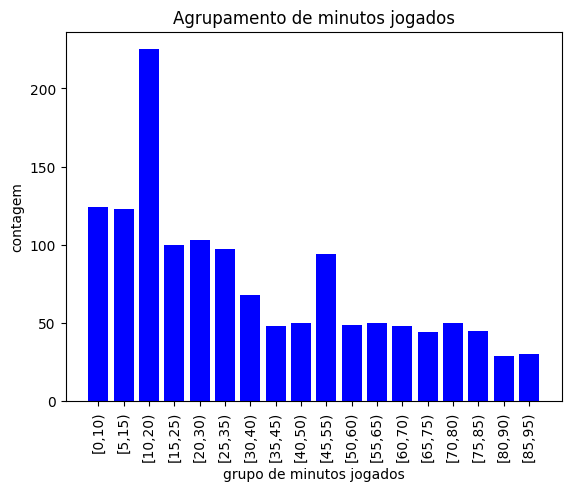

In [108]:
generic_bar_graph(contagem['categoria'], contagem['count'], x_label='grupo de minutos jogados', y_label='contagem', title='Agrupamento de minutos jogados', x_rotation=90)

##### Analisando estatisticas acima de 45 minutos e abaixo de 45 minutos

In [111]:
df_minutes_played[df_minutes_played['minutesPlayed'] <= 45].describe()

,rating,totalRating,countRating,goals,bigChancesCreated,bigChancesMissed,assists,goalsAssistsSum,accuratePasses,inaccuratePasses,totalPasses,accuratePassesPercentage,accurateOwnHalfPasses,accurateOppositionHalfPasses,accurateFinalThirdPasses,keyPasses,successfulDribbles,successfulDribblesPercentage,tackles,interceptions,yellowCards,directRedCards,redCards,accurateCrosses,accurateCrossesPercentage,totalShots,shotsOnTarget,shotsOffTarget,groundDuelsWon,groundDuelsWonPercentage,aerialDuelsWon,aerialDuelsWonPercentage,totalDuelsWon,totalDuelsWonPercentage,minutesPlayed,goalConversionPercentage,penaltiesTaken,penaltyGoals,penaltyWon,penaltyConceded,shotFromSetPiece,freeKickGoal,goalsFromInsideTheBox,goalsFromOutsideTheBox,shotsFromInsideTheBox,shotsFromOutsideTheBox,headedGoals,leftFootGoals,rightFootGoals,accurateLongBalls,accurateLongBallsPercentage,clearances,errorLeadToGoal,errorLeadToShot,dispossessed,possessionLost,possessionWonAttThird,totalChippedPasses,accurateChippedPasses,touches,wasFouled,fouls,hitWoodwork,ownGoals,dribbledPast,offsides,blockedShots,passToAssist,saves,cleanSheet,penaltyFaced,penaltySave,savedShotsFromInsideTheBox,savedShotsFromOutsideTheBox,goalsConcededInsideTheBox,goalsConcededOutsideTheBox,punches,runsOut,successfulRunsOut,highClaims,crossesNotClaimed,matchesStarted,penaltyConversion,setPieceConversion,totalAttemptAssist,totalContest,totalCross,duelLost,aerialLost,attemptPenaltyMiss,attemptPenaltyPost,attemptPenaltyTarget,totalLongBalls,goalsConceded,tacklesWon,tacklesWonPercentage,scoringFrequency,yellowRedCards,savesCaught,savesParried,totalOwnHalfPasses,totalOppositionHalfPasses,totwAppearances,goalKicks,ballRecovery,appearances,goalsPrevented,expectedAssists,expectedGoals,age,sum_gols_inside_outside
count,987.000000,987.000000,987.000000,987.000000,987.000000,987.000000,987.000000,987.000000,987.000000,987.000000,987.000000,987.000000,987.000000,987.000000,987.000000,987.000000,987.000000,987.000000,987.000000,987.000000,987.000000,987.000000,987.000000,987.000000,987.000000,987.000000,987.000000,987.000000,987.000000,987.000000,987.000000,987.000000,987.000000,987.000000,987.000000,987.000000,987.000000,987.000000,987.000000,987.000000,987.000000,987.0,987.000000,987.0,987.000000,987.000000,987.000000,987.000000,987.000000,987.000000,987.000000,987.000000,987.000000,987.000000,987.000000,987.000000,987.000000,987.000000,987.000000,987.000000,987.000000,987.00000,987.000000,987.000000,987.000000,987.000000,987.000000,987.000000,987.000000,987.0,987.000000,987.000000,987.000000,987.000000,987.000000,987.000000,987.0,987.000000,987.000000,987.000000,987.0,987.000000,987.000000,987.0,987.000000,987.000000,987.000000,987.000000,987.000000,987.0,987.0,987.0,987.000000,987.000000,987.000000,987.000000,987.000000,987.0,987.0,987.000000,987.000000,987.000000,987.000000,987.000000,987.000000,987.000000,987.000000,987.000000,987.000000,987.000000,987.000000
mean,5.663450,8.290578,1.264438,0.024316,0.016211,0.025329,0.016211,0.040527,6.006079,1.642351,7.648430,70.727346,2.703141,3.381966,1.717325,0.180344,0.194529,12.478892,0.469098,0.173252,0.077001,0.008105,0.008105,0.079027,4.821006,0.331307,0.096251,0.142857,0.963526,32.498410,0.351570,18.430078,1.315096,35.605954,18.898683,2.136103,0.001013,0.001013,0.001013,0.004053,0.006079,0.0,0.024316,0.0,0.218845,0.112462,0.006079,0.006079,0.012158,0.290780,15.187437,0.347518,0.007092,0.002026,0.295846,3.316109,0.088146,0.442756,0.199595,12.450861,0.302938,0.45998,0.005066,0.002026,0.248227,0.048632,0.092199,0.001013,0.028369,0.0,0.003040,0.001013,0.022290,0.006079,0.402229,0.073961,0.0,0.001013,0.001013,0.006079,0.0,0.027356,0.101317,0.0,0.179331,0.475177,0.421479,1.723404,0.472138,0.0,0.0,0.0,0.726444,0.476190,0.285714,20.119892,0.695035,0.0,0.0,0.003040,3.164134,4.905775,0.002026,0.045593,1.000000,1.630193,0.000297,0.009591,0.020986,22.891591,0.024316
std,2.261388,5.528721,0.840157,0.154107,0.126349,0.157203,0.126349,0.197291,6.581981,1.739282,7.569757,30.13064

In [112]:
df_minutes_played[df_minutes_played['minutesPlayed'] > 45].describe()

,rating,totalRating,countRating,goals,bigChancesCreated,bigChancesMissed,assists,goalsAssistsSum,accuratePasses,inaccuratePasses,totalPasses,accuratePassesPercentage,accurateOwnHalfPasses,accurateOppositionHalfPasses,accurateFinalThirdPasses,keyPasses,successfulDribbles,successfulDribblesPercentage,tackles,interceptions,yellowCards,directRedCards,redCards,accurateCrosses,accurateCrossesPercentage,totalShots,shotsOnTarget,shotsOffTarget,groundDuelsWon,groundDuelsWonPercentage,aerialDuelsWon,aerialDuelsWonPercentage,totalDuelsWon,totalDuelsWonPercentage,minutesPlayed,goalConversionPercentage,penaltiesTaken,penaltyGoals,penaltyWon,penaltyConceded,shotFromSetPiece,freeKickGoal,goalsFromInsideTheBox,goalsFromOutsideTheBox,shotsFromInsideTheBox,shotsFromOutsideTheBox,headedGoals,leftFootGoals,rightFootGoals,accurateLongBalls,accurateLongBallsPercentage,clearances,errorLeadToGoal,errorLeadToShot,dispossessed,possessionLost,possessionWonAttThird,totalChippedPasses,accurateChippedPasses,touches,wasFouled,fouls,hitWoodwork,ownGoals,dribbledPast,offsides,blockedShots,passToAssist,saves,cleanSheet,penaltyFaced,penaltySave,savedShotsFromInsideTheBox,savedShotsFromOutsideTheBox,goalsConcededInsideTheBox,goalsConcededOutsideTheBox,punches,runsOut,successfulRunsOut,highClaims,crossesNotClaimed,matchesStarted,penaltyConversion,setPieceConversion,totalAttemptAssist,totalContest,totalCross,duelLost,aerialLost,attemptPenaltyMiss,attemptPenaltyPost,attemptPenaltyTarget,totalLongBalls,goalsConceded,tacklesWon,tacklesWonPercentage,scoringFrequency,yellowRedCards,savesCaught,savesParried,totalOwnHalfPasses,totalOppositionHalfPasses,totwAppearances,goalKicks,ballRecovery,appearances,goalsPrevented,expectedAssists,expectedGoals,age,sum_gols_inside_outside
count,390.000000,390.000000,390.000000,390.000000,390.000000,390.000000,390.000000,390.000000,390.000000,390.00000,390.000000,390.000000,390.000000,390.000000,390.000000,390.000000,390.000000,390.00000,390.000000,390.000000,390.000000,390.000000,390.000000,390.000000,390.000000,390.000000,390.000000,390.000000,390.000000,390.000000,390.000000,390.000000,390.000000,390.000000,390.000000,390.000000,390.000000,390.000000,390.000000,390.000000,390.000000,390.000000,390.000000,390.000000,390.000000,390.000000,390.000000,390.000000,390.000000,390.000000,390.000000,390.000000,390.000000,390.000000,390.000000,390.000000,390.000000,390.000000,390.000000,390.000000,390.000000,390.000000,390.000000,390.000000,390.000000,390.000000,390.000000,390.000000,390.000000,390.0,390.0,390.0,390.000000,390.000000,390.000000,390.000000,390.000000,390.000000,390.000000,390.000000,390.0,390.000000,390.000000,390.000000,390.000000,390.000000,390.000000,390.000000,390.000000,390.0,390.0,390.0,390.000000,390.000000,390.000000,390.000000,390.000000,390.000000,390.0,390.000000,390.000000,390.000000,390.000000,390.000000,390.000000,390.000000,390.000000,390.000000,390.000000,390.000000,390.000000
mean,6.599835,20.316923,3.082051,0.076923,0.105128,0.120513,0.058974,0.135897,19.679487,5.50000,25.179487,75.412368,8.641026,11.320513,5.764103,0.707692,0.764103,28.09127,1.420513,0.607692,0.246154,0.007692,0.015385,0.282051,10.602564,1.164103,0.335897,0.464103,3.148718,44.090703,1.089744,33.456431,4.238462,43.696384,65.451282,4.186203,0.002564,0.002564,0.010256,0.010256,0.030769,0.002564,0.064103,0.012821,0.733333,0.430769,0.015385,0.012821,0.048718,1.035897,33.378860,0.951282,0.005128,0.005128,0.979487,10.807692,0.346154,1.556410,0.761538,40.453846,0.976923,1.294872,0.025641,0.002564,0.841026,0.166667,0.364103,0.005128,0.056410,0.0,0.0,0.0,0.030769,0.025641,1.169231,0.166667,0.015385,0.002564,0.002564,0.007692,0.0,0.307692,0.256410,0.256410,0.702564,1.697436,1.353846,5.500000,1.523077,0.0,0.0,0.0,2.353846,1.335897,0.846154,39.341880,4.744872,0.007692,0.0,0.017949,10.138462,16.394872,0.005128,0.110256,3.361538,3.528205,-0.008718,0.036902,0.075931,24.028205,0.076923
std,0.237369,9.368441,1.424514,0.276279,0.346446,0.363275,0.235879,0.37873

##### Analisando estatisticas para quem joga mais que 90 minutos

In [115]:
df_statistics[df_statistics['minutesPlayed'] > 90].iloc[:, 22:].describe()

,rating,totalRating,countRating,goals,bigChancesCreated,bigChancesMissed,assists,goalsAssistsSum,accuratePasses,inaccuratePasses,totalPasses,accuratePassesPercentage,accurateOwnHalfPasses,accurateOppositionHalfPasses,accurateFinalThirdPasses,keyPasses,successfulDribbles,successfulDribblesPercentage,tackles,interceptions,yellowCards,directRedCards,redCards,accurateCrosses,accurateCrossesPercentage,totalShots,shotsOnTarget,shotsOffTarget,groundDuelsWon,groundDuelsWonPercentage,aerialDuelsWon,aerialDuelsWonPercentage,totalDuelsWon,totalDuelsWonPercentage,minutesPlayed,goalConversionPercentage,penaltiesTaken,penaltyGoals,penaltyWon,penaltyConceded,shotFromSetPiece,freeKickGoal,goalsFromInsideTheBox,goalsFromOutsideTheBox,shotsFromInsideTheBox,shotsFromOutsideTheBox,headedGoals,leftFootGoals,rightFootGoals,accurateLongBalls,accurateLongBallsPercentage,clearances,errorLeadToGoal,errorLeadToShot,dispossessed,possessionLost,possessionWonAttThird,totalChippedPasses,accurateChippedPasses,touches,wasFouled,fouls,hitWoodwork,ownGoals,dribbledPast,offsides,blockedShots,passToAssist,saves,cleanSheet,penaltyFaced,penaltySave,savedShotsFromInsideTheBox,savedShotsFromOutsideTheBox,goalsConcededInsideTheBox,goalsConcededOutsideTheBox,punches,runsOut,successfulRunsOut,highClaims,crossesNotClaimed,matchesStarted,penaltyConversion,setPieceConversion,totalAttemptAssist,totalContest,totalCross,duelLost,aerialLost,attemptPenaltyMiss,attemptPenaltyPost,attemptPenaltyTarget,totalLongBalls,goalsConceded,tacklesWon,tacklesWonPercentage,scoringFrequency,yellowRedCards,savesCaught,savesParried,totalOwnHalfPasses,totalOppositionHalfPasses,totwAppearances,goalKicks,ballRecovery,id,appearances,goalsPrevented,expectedAssists,expectedGoals,age,sum_gols_inside_outside
count,9858.000000,9858.000000,9858.000000,9858.000000,9858.000000,9858.000000,9858.000000,9858.000000,9858.000000,9858.000000,9858.000000,9858.000000,9858.000000,9858.000000,9858.000000,9858.000000,9858.000000,9858.000000,9858.000000,9858.000000,9858.000000,9858.000000,9858.000000,9858.000000,9858.000000,9858.000000,9858.000000,9858.000000,9858.000000,9858.000000,9858.000000,9858.000000,9858.000000,9858.000000,9858.000000,9858.000000,9858.000000,9858.000000,9858.000000,9858.000000,9858.000000,9858.000000,9858.000000,9858.000000,9858.000000,9858.000000,9858.000000,9858.000000,9858.000000,9858.000000,9858.000000,9858.000000,9858.000000,9858.000000,9858.000000,9858.000000,9858.000000,9858.000000,9858.000000,9858.000000,9858.000000,9858.000000,9858.000000,9858.000000,9858.000000,9858.000000,9858.000000,9858.000000,9858.000000,9858.000000,9858.000000,9858.000000,9858.000000,9858.000000,9858.000000,9858.000000,9858.000000,9858.000000,9858.000000,9858.000000,9858.000000,9858.000000,9858.000000,9858.000000,9858.000000,9858.000000,9858.000000,9858.000000,9858.000000,9858.000000,9858.000000,9858.000000,9858.000000,9858.000000,9858.000000,9858.000000,9858.000000,9858.000000,9858.000000,9858.000000,9858.000000,9858.000000,9858.000000,9858.000000,9858.000000,9.858000e+03,9858.000000,9858.000000,9858.000000,9858.000000,9858.000000,9858.000000
mean,6.861178,138.419375,20.036823,1.805336,2.029418,1.671333,1.252485,3.057821,467.604687,111.264354,578.869040,77.961750,247.115439,226.442078,107.077703,12.966728,10.327653,47.598542,21.526273,11.787584,2.842362,0.082065,0.144147,5.952830,18.737451,17.364983,5.941165,6.865490,46.878779,50.421824,19.488639,47.781035,66.367417,51.287833,1326.434064,7.731935,0.201867,0.156827,0.150436,0.200954,0.570400,0.029012,1.552648,0.252688,10.922297,6.442686,0.297018,0.554676,0.943802,35.205113,47.756572,25.499594,0.154900,0.237371,11.173666,180.415094,5.401501,44.778758,22.519578,830.743559,15.394603,16.133800,0.447352,0.049503,10.314263,2.315175,4.558328,0.109759,4.032562,2.281193,0.199229,0.032258,2.540272,1.442078,17.465916,2.767600,0.526679,0.538547,0.512680,1.015926,0.018259,14.738182,7.189033,0.767258,12.856969,20.661798,24.175492,66.270643,19.458409,0.005985,0.006188,0.032867,

#### Analisando estatisticas de jogadores outliers na idade

- Depois de remover os jogadores com baixa frequencia, aparentemente há estatisticas boas para poucos outliers na idade que sobraram. Acho que vale apena manter

In [116]:
# Calcular Q1, Q3 e IQR
Q1 = df_statistics['age'].quantile(0.25)
Q3 = df_statistics['age'].quantile(0.75)
IQR = Q3 - Q1

# Definir limites para outliers
limite_inferior = Q1 - 1.5 * IQR
limite_superior = Q3 + 1.5 * IQR

# Filtrar apenas os outliers
outliers = df_statistics[((df_statistics['age'] < limite_inferior) & (df_statistics['minutesPlayed'] > 90)) | 
              ((df_statistics['age'] > limite_superior) & (df_statistics['minutesPlayed'] > 90))]

len(outliers)

23

In [121]:
max(outliers['age'])

44.0

In [122]:
min(outliers['age'])

41.0

In [120]:
outliers.iloc[:, 22:].describe()

,rating,totalRating,countRating,goals,bigChancesCreated,bigChancesMissed,assists,goalsAssistsSum,accuratePasses,inaccuratePasses,totalPasses,accuratePassesPercentage,accurateOwnHalfPasses,accurateOppositionHalfPasses,accurateFinalThirdPasses,keyPasses,successfulDribbles,successfulDribblesPercentage,tackles,interceptions,yellowCards,directRedCards,redCards,accurateCrosses,accurateCrossesPercentage,totalShots,shotsOnTarget,shotsOffTarget,groundDuelsWon,groundDuelsWonPercentage,aerialDuelsWon,aerialDuelsWonPercentage,totalDuelsWon,totalDuelsWonPercentage,minutesPlayed,goalConversionPercentage,penaltiesTaken,penaltyGoals,penaltyWon,penaltyConceded,shotFromSetPiece,freeKickGoal,goalsFromInsideTheBox,goalsFromOutsideTheBox,shotsFromInsideTheBox,shotsFromOutsideTheBox,headedGoals,leftFootGoals,rightFootGoals,accurateLongBalls,accurateLongBallsPercentage,clearances,errorLeadToGoal,errorLeadToShot,dispossessed,possessionLost,possessionWonAttThird,totalChippedPasses,accurateChippedPasses,touches,wasFouled,fouls,hitWoodwork,ownGoals,dribbledPast,offsides,blockedShots,passToAssist,saves,cleanSheet,penaltyFaced,penaltySave,savedShotsFromInsideTheBox,savedShotsFromOutsideTheBox,goalsConcededInsideTheBox,goalsConcededOutsideTheBox,punches,runsOut,successfulRunsOut,highClaims,crossesNotClaimed,matchesStarted,penaltyConversion,setPieceConversion,totalAttemptAssist,totalContest,totalCross,duelLost,aerialLost,attemptPenaltyMiss,attemptPenaltyPost,attemptPenaltyTarget,totalLongBalls,goalsConceded,tacklesWon,tacklesWonPercentage,scoringFrequency,yellowRedCards,savesCaught,savesParried,totalOwnHalfPasses,totalOppositionHalfPasses,totwAppearances,goalKicks,ballRecovery,id,appearances,goalsPrevented,expectedAssists,expectedGoals,age,sum_gols_inside_outside
count,23.000000,23.000000,23.000000,23.000000,23.000000,23.000000,23.000000,23.000000,23.000000,23.000000,23.000000,23.000000,23.000000,23.000000,23.000000,23.000000,23.000000,23.000000,23.000000,23.000000,23.000000,23.000000,23.000000,23.000000,23.000000,23.000000,23.000000,23.000000,23.000000,23.000000,23.000000,23.000000,23.000000,23.000000,23.000000,23.000000,23.000000,23.000000,23.0,23.000000,23.000000,23.0,23.000000,23.000000,23.000000,23.000000,23.000000,23.000000,23.000000,23.000000,23.000000,23.000000,23.000000,23.000000,23.000000,23.000000,23.000000,23.000000,23.000000,23.000000,23.000000,23.000000,23.000000,23.000000,23.000000,23.000000,23.000000,23.0,23.000000,23.000000,23.000000,23.000000,23.000000,23.000000,23.000000,23.000000,23.000000,23.000000,23.000000,23.000000,23.0,23.000000,23.000000,23.0,23.000000,23.000000,23.000000,23.000000,23.000000,23.0,23.0,23.0,23.000000,23.000000,23.000000,23.000000,23.000000,23.000000,23.000000,23.000000,23.000000,23.000000,23.000000,23.000000,23.000000,2.300000e+01,23.000000,23.000000,23.000000,23.000000,23.000000,23.000000
mean,6.895396,108.326087,15.652174,0.608696,1.217391,0.304348,0.565217,1.173913,422.565217,103.130435,525.695652,75.821505,278.043478,148.869565,58.913043,7.086957,1.739130,24.192273,10.869565,6.652174,2.826087,0.304348,0.391304,4.347826,9.101318,6.086957,2.217391,2.304348,20.652174,43.357833,14.000000,68.145577,34.652174,63.669566,1115.173913,3.523044,0.086957,0.086957,0.0,0.347826,0.086957,0.0,0.565217,0.043478,4.173913,1.913043,0.043478,0.260870,0.304348,48.739130,43.777719,20.739130,0.217391,0.304348,3.347826,128.913043,2.000000,58.434783,27.913043,668.608696,8.478261,9.347826,0.130435,0.086957,4.130435,0.869565,1.565217,0.0,13.565217,2.826087,0.434783,0.130435,8.304348,5.173913,12.608696,1.913043,2.347826,1.043478,1.000000,2.782609,0.0,12.869565,8.695652,0.0,7.086957,4.347826,13.521739,29.260870,10.608696,0.0,0.0,0.0,112.217391,14.521739,6.652174,37.391333,366.532609,0.086957,0.173913,2.478261,304.652174,234.565217,0.913043,39.478261,76.347826,1.198740e+06,16.347826,0.862661,0.348325,0.338561,42.043478,0.608696
std,0.286329,77.288081,10.994249,1.157550,2.235184,0.926125,1.273010,2.208500,573.064872,88.618849,629.743847,10.284

## Resultados da EDA

- Jogadores que não tem heatmap, position, que faleceram ou estão aposentados ou não tem idade dados relacionados a idade foram retirados do dataset. Isso garante que apenas jogadores que jogaram e tem dados relevantes serão considerados na análise
- Alguns jogadores não tem a altura computada. Esses valores serão inseridos na etapa de pré processamento.
- A variável preferredFoot, se for utilizada, também será preenchida na etapa de pré-processamento para valores nulos
- Algumas estatísticas estavam sem valores preenchidos. Elas serão imputadas na etapa de pré processamento
- Filtrei apenas dados da última temporada disponível pois nem todos os jogadores que jogaram em uma liga em 2023 estão na mesma liga em 2024. Para resolver isso, teria que ser refeita a ingestão os dados e também adicionaria uma complexidade a mais na análise. Pode ser um ponto de melhoria futuro.
- Um outlier com a idade errada computada foi removido do dataset para não atrapalhar o algoritmo
- A variável de altura tem outliers, mas são dentro de um padrão aceitável, e remover eles não faria sentido pois podemos perder jogadores valiosos para equipes
- As varáveis de estatística possuem uma discrepância grande entre o terceiro quartil e o ultimo. Isso pode ocorrer por jogadores que são realmente acima da média
- Jogadores com poucos jogos influênciam negativamente análise de porcentagem, visto que vários possuem 100% de acerto de passe, mas jogaram quinze minutos e fizeram um passe só.
- Além disso, as variáveis de porcentagem do jeito que estão no dataset podem não ser interessantes, visto que jogadores com baixa estatística poderiam ser comparados a jogadores com alta estatística só por terem a mesma porcentagem de acerto. Em alguns casos, pode ser válido, em outros, como jogadores com apenas 1 ponto computado e um acerto, pode ser apenas acaso.
- Seria interessante montar estatisticas de acurácia mais robustas, como passses ou penaltis defendidos, que levem em consideração o tempo que o jogador ficou em campo
- Jogadores que jogaram menos de noventa minutos não deveriam ser contabilizados. Muitos jogaram menos de dez minutos na temporada, então pode não ser justo uma análise desse tipo.
- Matches, appearances e minutesPlayed são coisas diferentes, mas são relacionadas ao quanto o jogador jogou ou apareceu em campo. Acho mais interessante usar o número de minutos jogados
- Já construí métodos para tratar os valores nulos
- XG e XA não é computado para todas as ligas. Aparentemente também não é computador para jogadores que jogam pouco em outras ligas.
- Todas as distribuições de variáveis de estatísticas são logaritmicas
- Alguns jogadores mais velhos não necessáriamente precisam ser retirados. Alguns deles tem estatísticas bem relevantes, e pode ser algo útil para algum time menor

# Pré-processamento

O que posso fazer até aqui?

- Remover jogadores aposentados, falecidos e com poucos stats (olhar as análises de heatmap, position, age, matches e jogadores falecidos)
- Transformar o heatmap em algo útil
- Classificar qual tipo de jogador com base nas posições que ele ocupa
- Adicionar a altura em jogadores que não tem
- Inserir a moda para jogadores sem o pé preferencial
- Talvez agrupar a variável de altura em bins mais arredondados - ex: um grupo de 170 a 180
- Remover jogadores com mais de 60 anos
- Pensar em algo que possa transformar a variável matches em algum indice de regularidade
- Com a variável positions, posso criar uma variável que indica se o jogador joga em mais de uma posição
- Necessário converter as estatísticas para uma relação por jogo, para evitar que jogadores com poucos jogos parecam super craques ( pelo menos as estatisticas individuais )
- Testar a conversão para porcentagem após a conversão feita acima
- Filtrar para pelo menos o jogador ter jogado um jogo completo
- Todas as variáveis de porcentagem que existem atualmente não serão usadas
- Talvez fazer um indice com errorLeadingtoGoal e errorLeadingtoShot
- Criar e analsiar uma métrica de acurácia de chute: totalShots, shotsOnTarget, hitWoodwork, shotsOffTarget
- Criar e analisar uma métrica de gols com a perna ruim com leftFootGoals e rightFootGoals

# Modelagem

- fazer teste com as características de passe: accuratePasses, inaccuratePasses, totalPasses em um modelo e accuratePassesPercentage em outro
- mesma coisa com accurateCrosses e accurateCrossesPercentage do passo acima
- Fazer um teste, tirando o número total de cada tipo de passe e deixando só o quanto o jogador acertou